# RICH AI Exploratory Data Analysis

Notes
- Labels are 0: Muon, 1: Pion, 2: Positron
- Likelihood labels are different [Pion, Muon, Positron]

In [1]:
import h5py 
import numpy as np 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import glob

# Helper functions

In [2]:
def read_RICHAI_data(file_paths):
    """Read in all the 2018 RICHAI data
    
    Parameters
    ----------
    file_paths : list of str
        List of file paths of all data sets.
        
    Returns
    -------
    data_files : dict
        Dictionary of HFD data sets     
    """
    data_files = {}
    for file_path in file_paths:
        name = file_path.split("/")[4] + "/" + file_path.split("/")[5].split(".")[0]
        data_files[name] = h5py.File(file_path)
    
    return data_files

In [3]:
def events_to_pandas(dfile):
    """Convert HDF5 events data to Pandas
    
    Parameters
    ----------
    dfile : HDF5 file
        The RICHAI HDF5 file to convert to pandas.
        
    Returns
    -------
    df : pd.DataFrame
        pandas DataFrame with Events data
    """
    
    df = pd.DataFrame()
    
    # event features
    df["run_id"] = dfile["Events"]["run_id"]
    df["burst_id"] = dfile["Events"]["burst_id"]
    df["event_id"] = dfile["Events"]["event_id"]
    df["track_id"] = dfile["Events"]["track_id"]
    df["track_momentum"] = dfile["Events"]["track_momentum"]
    df["chod_time"] = dfile["Events"]["chod_time"]
    df["ring_radius"] = dfile["Events"]["ring_radius"]
    df["ring_centre_pos_x"] = dfile["Events"]["ring_centre_pos"][:, 0]
    df["ring_centre_pos_y"] = dfile["Events"]["ring_centre_pos"][:, 1]
    df["ring_likelihood_pion"] = dfile["Events"]["ring_likelihood"][:, 0]
    df["ring_likelihood_muon"] = dfile["Events"]["ring_likelihood"][:, 1]
    df["ring_likelihood_positron"] = dfile["Events"]["ring_likelihood"][:, 2]
    
    # labels
    mu_off = dfile.attrs["muon_offset"]
    pi_off = dfile.attrs["pion_offset"]
    pos_off = dfile.attrs["positron_offset"]
    entries = dfile.attrs["entries"]
    
    labels = np.zeros(entries, dtype=np.int32)
    labels[mu_off:pi_off] = 0
    labels[pi_off:pos_off] = 1
    labels[pos_off:] = 2
    
    df["label"] = labels
    
    # hit mapping values
    df["first_hit"] = np.array(dfile["HitMapping"])[:-1]  # hit n
    df["last_hit"] = np.array(dfile["HitMapping"])[1:]    # hit n + 1
    df["total_hits"] = df["last_hit"] - df["first_hit"]
    
    return df

In [4]:
def get_string_label(label):
    """Add string label to pandas df (to be used with map)"""
    if label == 0:
        return "muon"
    elif label == 1:
        return "pion"
    elif label == 2:
        return "positron"

In [5]:
def compute_seq_id(hit, or_id=0):
    """Compute the RICH PMT sequence ID"""
    disk_id, pm_id, sc_id, up_dw_id, _ = hit
    
    if or_id < 1:
        seq_id = sc_id * 8 + pm_id + up_dw_id * 61 * 8 + disk_id * 61 * 8 * 2
    else:
        seq_id = 61 * 8 * 2 * 2 + sc_id + up_dw_id * 61 + disk_id * 61 * 2
    return int(seq_id)

compute_seq_id = np.vectorize(compute_seq_id, otypes=[int])

In [6]:
def get_hit_info_df(f, df, event):
    """Get the hit info for an event in a pandas dataframe
    
    Parameters
    ----------
    f : HDF5 file
        The RICHAI HDF5 file.
    df : pandas DataFrame
        A pandas DataFrame representation of the HDF5 Events file.
    event : int
        The event number to get the hit info for.
        
    Returns
    -------
    positions : pd.DataFrame
        pandas DataFrame with hits data for a given event
    """
    positions = []
    
    # get our hit data for this event
    idx_from = df.loc[event]["first_hit"]
    idx_to = df.loc[event]["last_hit"]
    hit_data = f["Hits"][idx_from:idx_to]
    
    # get our pm locations for this event
    for hit in hit_data:
        pm_idx = compute_seq_id(hit)
        positions.append(position_map[pm_idx])
    
    # add hit time, chod time, and delta
    positions = pd.DataFrame(positions, columns=["x", "y", "mirror"])
    positions["hit_time"] = hit_data["hit_time"]
    positions["chod_time"] = df["chod_time"][event]
    positions["chod_delta"] = positions["hit_time"] - positions["chod_time"]
    positions["class"] = df["class"][event]
    positions["event"] = event
    
    return positions

In [7]:
def draw_pmt_pos(ax,pmt_pos):
    """
        Add circle patches corresponding to the PMT position to the Axes object ax
    """
    for i in pmt_pos:
        if i[2] == 0: # 0: Jura / 1: Salève, PMT disks are identical, we can pick either one. [TODO: CHECK!]
            ax.add_patch(plt.Circle((i[0],i[1]),1.0, color='black'))
    return ax

In [8]:
def get_class_samples(df, n, seed, momentum_bin=None):
    """Sample n samples for each particle class from the events dataframe"""
    
    if momentum_bin is not None:
        df = df.query("momentum_bin == @momentum_bin")
        
    samples = pd.concat(
        [
            df[df["class"] == "muon"].sample(n=n, random_state=seed),
            df[df["class"] == "pion"].sample(n=n, random_state=seed),
            df[df["class"] == "positron"].sample(n=n, random_state=seed)        
        ]

    )
    
    return samples

# Read in data files

In [9]:
file_paths = glob.glob("/data/bvelghe/capstone2022/*/*")
data_files = read_RICHAI_data(file_paths)
data_files.keys()

dict_keys(['A/Run008563', 'A/Run008548', 'A/Run008564', 'A/Run008553', 'A/Run008562', 'C/2018E', 'B/2018B'])

In [10]:
f = data_files["A/Run008563"]
f.keys()

<KeysViewHDF5 ['Events', 'HitMapping', 'Hits']>

In [11]:
position_map = np.load("/home/nico/RICHPID/tools/rich_pmt_positions.npy")
position_map.shape

(1952, 3)

# Create `Events` pandas `DataFrame`

<div class="alert alert-warning">
The very last event has 6m hits?
</div>

In [12]:
df = events_to_pandas(f)

# add class label (text)
df["class"] = df["label"].apply(get_string_label)

# add momentum bin
momentum_bins = ['0-9', '10-19', '20-29', '30-39','40+']
df["momentum_bin"] = pd.cut(
    df["track_momentum"],
    [0, 10, 20, 30, 40, np.inf],
    labels=momentum_bins
)

df.shape

(181847, 18)

In [13]:
df

run_id  burst_id  event_id  track_id  track_momentum  chod_time  \
0         8563      1502     19187         0       29.086382  24.875072   
1         8563      1502     43695         0       29.131575  23.019239   
2         8563      1502     53258         0       53.725155   7.871216   
3         8563      1502     79840         1       45.426033  15.969522   
4         8563      1502     88854         0       51.754585  23.295773   
...        ...       ...       ...       ...             ...        ...   
181842    8563         6   1901718         0        9.632858  19.408539   
181843    8563         7   1153616         0       29.055141  18.719345   
181844    8563         8    998857         0       28.937969   5.329090   
181845    8563         8   1107423         0       27.879078   1.462662   
181846    8563         9    901434         0       23.955732  17.404152   

        ring_radius  ring_centre_pos_x  ring_centre_pos_y  \
0        181.268814          -4.406287          31.420258   
1        180.360535         -33.380520          81.289101   
2        187.981369        -124.974808         -26.034964   
3        181.346909        -159.838486         -44.940845   
4        186.581955        -131.870239         -39.216457   
...             ...                ...                ...   
181842   191.426300        -341.561005         -60.012337   
181843   189.682892        -217.117447         -70.349503   
181844   188.283539        -201.229034          66.584831   
181845   192.117065        -120.966507          47.340836   
181846   189.807541        -200.585602          86.105621   

        ring_likelihood_pion  ring_likelihood_muon  ring_likelihood_positron  \
0               1.229546e-08          1.000000e+00              9.656426e-02   
1               2.874574e-05          1.000000e+00              1.647658e-09   
2               3.173104e-01          1.000000e+00              9.871307e-02   
3               1.382166e-01          1.000000e+00              2.374848e-01   
4               7.380376e-01          1.000000e+00              5.661391e-02   
...                      ...                   ...                       ...   
181842          1.216099e-37          1.216099e-37              1.000000e+00   
181843          6.483635e-36          8.388432e-11              1.000000e+00   
181844          1.116412e-17          1.061459e-04              1.000000e+00   
181845          2.396222e-32          3.192111e-11              1.000000e+00   
181846          3.521474e-31          2.751138e-09              1.000000e+00   

        label  first_hit  last_hit  total_hits     class momentum_bin  
0           0          0        16          16      muon        20-29  
1           0         16        38          22      muon        20-29  
2           0         38        68          30      muon          40+  
3           0         68       109          41      muon          40+  
4           0        109       134          25      muon          40+  
...       ...        ...       ...         ...       ...          ...  
181842      2      82065     82087          22  positron          0-9  
181843      2      82087     82129          42  positron        20-29  
181844      2      82129     82196          67  positron        20-29  
181845      2      82196     82214          18  positron        20-29  
181846      2      82214   6856199     6773985  positron        20-29  

[181847 rows x 18 columns]

In [14]:
# this matches Bob's documentation on https://github.com/TRIUMF-Capstone2022/RICHPID/tree/main/docs
df["class"].value_counts()

muon        162478
pion         17602
positron      1767
Name: class, dtype: int64

# Plots: Event Data

## Distribution of track momentum for each particle

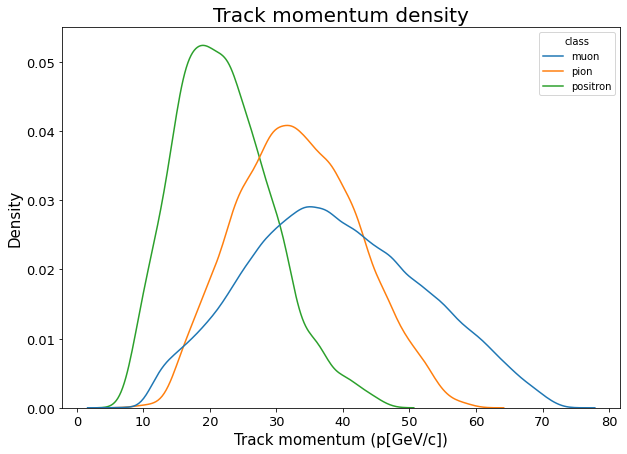

In [15]:
plt.figure(figsize=(10, 7))
sns.kdeplot(df["track_momentum"], hue=df["class"], common_norm=False, palette="tab10")
plt.title("Track momentum density", fontsize=20)
plt.xlabel("Track momentum (p[GeV/c])", fontsize=15);
plt.ylabel("Density", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

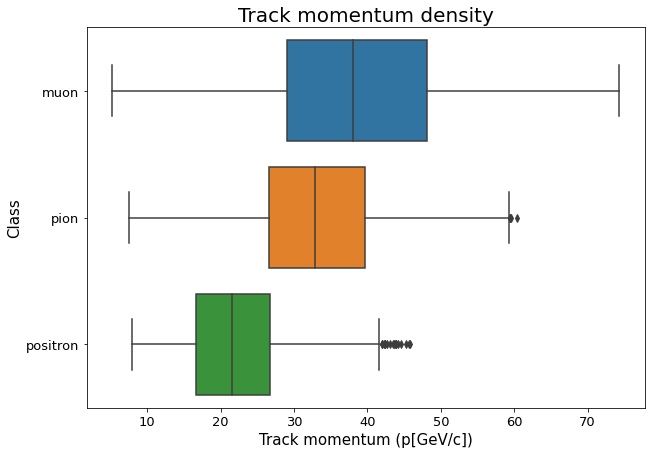

In [16]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x="track_momentum", y="class", palette="tab10")
plt.title("Track momentum density", fontsize=20)
plt.xlabel("Track momentum (p[GeV/c])", fontsize=15);
plt.ylabel("Class", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

## Distribution of ring radius for each particle

<div class="alert alert-warning">
Some ring radius values are equal to 999,999 or greater, is this an error in the data?  See below:
</div>

In [17]:
df[df["ring_radius"] >= 999999.000]

run_id  burst_id  event_id  track_id  track_momentum  chod_time  \
99        8563      1502   1754876         0        9.472846  15.354265   
418       8563      1505   1864199         1       45.689087  15.251482   
2121      8563      1487    684736         1       55.891708  35.145298   
2713      8563      1472    835945         1       36.513718   8.213794   
3092      8563      1475   1228709         1       57.885632  32.871189   
...        ...       ...       ...       ...             ...        ...   
180800    8563       904    370741         0       19.951565  19.565580   
180817    8563       889   1912114         0       31.217012  18.794067   
180830    8563       881   1838906         0       16.281887  18.677586   
181489    8563       315    847344         0       16.432795  23.136395   
181585    8563       228   2045072         0       18.764105   6.359902   

        ring_radius  ring_centre_pos_x  ring_centre_pos_y  \
99         999999.0           999999.0           999999.0   
418        999999.0           999999.0           999999.0   
2121       999999.0           999999.0           999999.0   
2713       999999.0           999999.0           999999.0   
3092       999999.0           999999.0           999999.0   
...             ...                ...                ...   
180800     999999.0           999999.0           999999.0   
180817     999999.0           999999.0           999999.0   
180830     999999.0           999999.0           999999.0   
181489     999999.0           999999.0           999999.0   
181585     999999.0           999999.0           999999.0   

        ring_likelihood_pion  ring_likelihood_muon  ring_likelihood_positron  \
99              1.216099e-37          1.216099e-37              1.216099e-37   
418             1.216099e-37          1.216099e-37              1.216099e-37   
2121            1.216099e-37          1.216099e-37              1.216099e-37   
2713            1.216099e-37          1.216099e-37              1.216099e-37   
3092            1.216099e-37          1.216099e-37              1.216099e-37   
...                      ...                   ...                       ...   
180800          1.216099e-37          1.216099e-37              1.216099e-37   
180817          3.983476e-02          3.510035e-03              1.808248e-04   
180830          3.837442e-01          2.039289e-04              1.742545e-03   
181489          1.216099e-37          1.216099e-37              1.216099e-37   
181585          8.560977e-04          2.112621e-04              5.951482e-04   

        label  first_hit  last_hit  total_hits     class momentum_bin  
99          0       3913      3944          31      muon          0-9  
418         0      15884     15922          38      muon          40+  
2121        0      77925     77980          55      muon          40+  
2713        0     100290    100341          51      muon        30-39  
3092        0     114000    114064          64      muon          40+  
...       ...        ...       ...         ...       ...          ...  
180800      2      32586     32653          67  positron        10-19  
180817      2      33488     33597         109  positron        30-39  
180830      2      34169     34217          48  positron        10-19  
181489      2      65498     65529          31  positron        10-19  
181585      2      70003     70056          53  positron        10-19  

[305 rows x 18 columns]

<div class="alert alert-warning">
There appears to be an outlier in this dataset, look at the radius, and centre values below:
</div>

In [18]:
df.iloc[158966]

run_id                             8563
burst_id                             40
event_id                         854840
track_id                              0
track_momentum                61.809074
chod_time                     23.413464
ring_radius                 1256322.875
ring_centre_pos_x          -1088155.625
ring_centre_pos_y            628279.625
ring_likelihood_pion             0.0961
ring_likelihood_muon           0.360728
ring_likelihood_positron            1.0
label                                 0
first_hit                       5949332
last_hit                        5949355
total_hits                           23
class                              muon
momentum_bin                        40+
Name: 158966, dtype: object

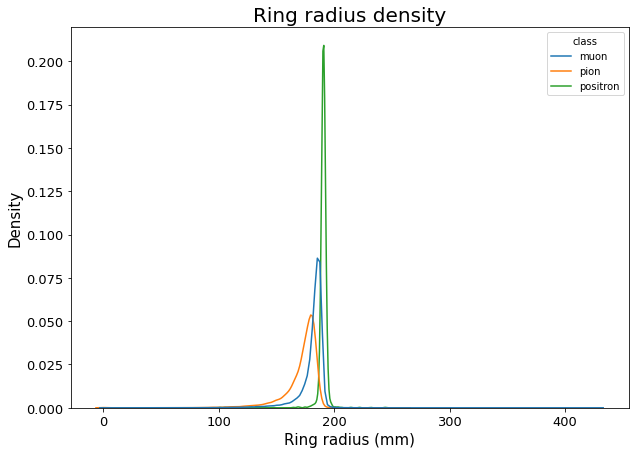

In [19]:
plt.figure(figsize=(10, 7))
sns.kdeplot(
    x=df.query("ring_radius < 999999.000")["ring_radius"],
    hue=df.query("ring_radius < 999999.000")["class"],
    common_norm=False,
    palette="tab10"
)
plt.title("Ring radius density", fontsize=20)
plt.xlabel("Ring radius (mm)", fontsize=15);
plt.ylabel("Density", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

## Distribution of ring radius for each particle faceted by momentum bin

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


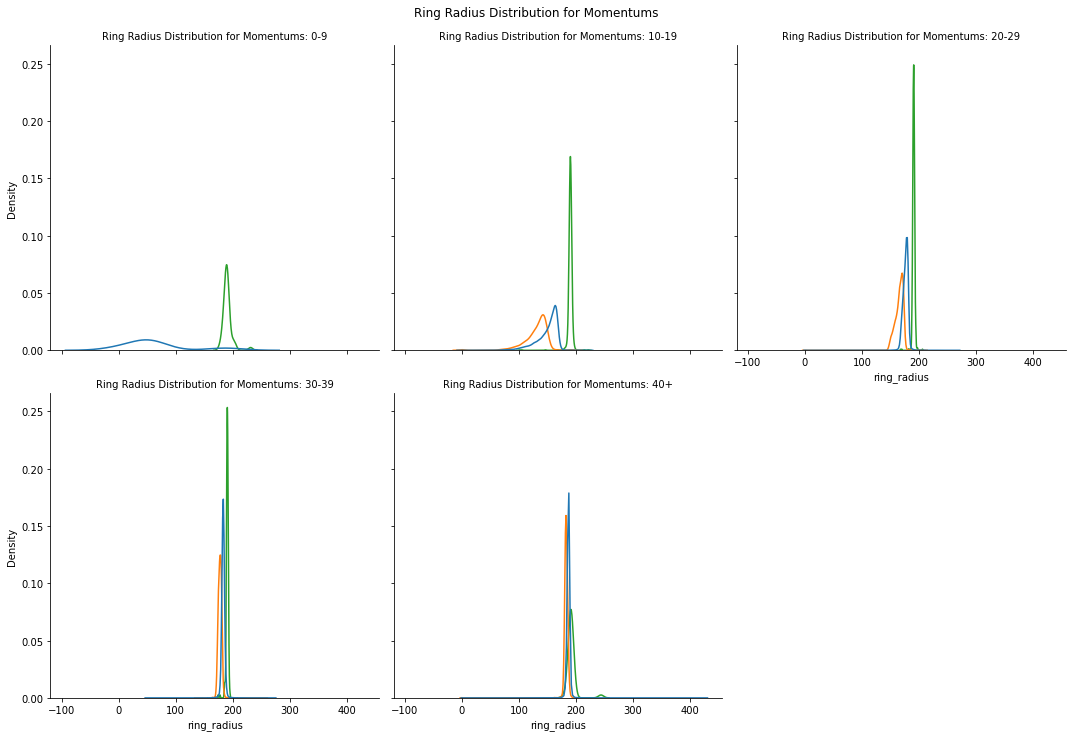

In [20]:
g = sns.displot(
    x=df.query("ring_radius < 999999.000")["ring_radius"],
    col=df.query("ring_radius < 999999.000")["momentum_bin"],
    hue=df.query("ring_radius < 999999.000")["class"],
    palette="tab10",
    legend=False,
    col_wrap=3,
    kind="kde",
    common_norm=False,
);

g.set_titles("Ring Radius Distribution for Momentums: {col_name}")
g.tight_layout()
g.fig.suptitle("Ring Radius Distribution for Momentums", y=1.02)
plt.show()

<!-- ## Location of Ring Centres for Each Particle -->

## Ring centre locations for each particle

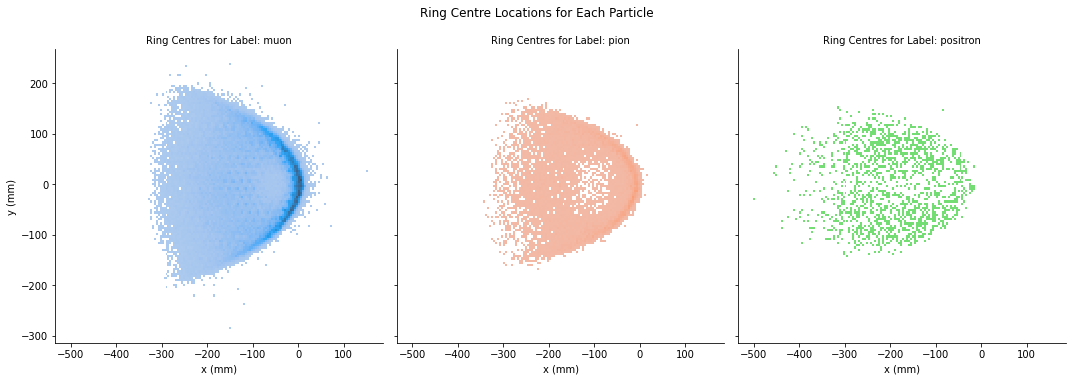

In [21]:
g = sns.displot(
    x=df.query("ring_centre_pos_y < 500000.000")["ring_centre_pos_x"],
    y=df.query("ring_centre_pos_y < 500000.000")["ring_centre_pos_y"],
    col=df.query("ring_centre_pos_y < 500000.000")["class"],
    hue=df.query("ring_centre_pos_y < 500000.000")["class"],
    palette="tab10",
    legend=False
);

g.fig.set_figheight(5)
g.fig.set_figwidth(15)
g.set_axis_labels("x (mm)", "y (mm)")
g.set_titles("Ring Centres for Label: {col_name}")
g.tight_layout()
g.fig.suptitle("Ring Centre Locations for Each Particle", y=1.05)
plt.show()

## Track momentum vs. Ring radius

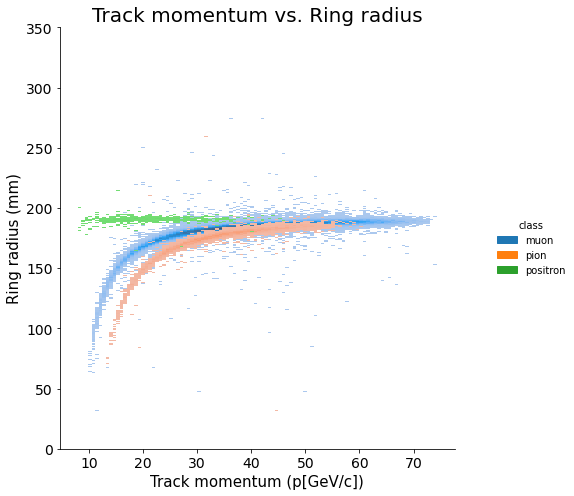

In [22]:
g = sns.displot(
    x=df.query("ring_centre_pos_y < 500000.000")["track_momentum"],
    y=df.query("ring_centre_pos_y < 500000.000")["ring_radius"],
    hue=df.query("ring_centre_pos_y < 500000.000")["class"],
    palette="tab10",
);


g.ax.set_title("Track momentum vs. Ring radius", fontsize=20)
g.set_axis_labels("Track momentum (p[GeV/c])", "Ring radius (mm)", fontsize=15)
g.set_titles("Ring Centres for Label: {col_name}")
g.ax.tick_params(axis='x', labelsize= 14)
g.ax.tick_params(axis='y', labelsize= 14)
g.ax.set_ylim([0, 350])    # some noise above 350 makes the plot ugly
g.fig.set_figheight(7)
g.fig.set_figwidth(8)
g.tight_layout()
plt.show()

# Plots: Hits Data

## Note on last event

<div class="alert alert-warning">
It looks like our last event has 6M hits?  Is this correct? Something with the sentinal value?
</div>

In [23]:
f["HitMapping"][-2]

82214

In [24]:
f["HitMapping"][-1]

6856199

In [25]:
len(f["Hits"][f["HitMapping"][-2]:f["HitMapping"][-1]])

6773985

## Note on problematic HitMapping values

<div class="alert alert-warning">
For event 162,477 if we index `Hits` from 162,477 to 162,478 we would get no hits due to the below?
    
Same logic for event 180,079
</div>

In [26]:
df.query("total_hits < 0")

run_id  burst_id  event_id  track_id  track_momentum  chod_time  \
162477    8563        10   2127576         0       45.107151   5.858219   
180079    8563        10   2100708         0       27.119833  11.933970   

        ring_radius  ring_centre_pos_x  ring_centre_pos_y  \
162477   186.400986         -35.000172          73.605415   
180079   172.741959        -100.906670         105.466911   

        ring_likelihood_pion  ring_likelihood_muon  ring_likelihood_positron  \
162477                   1.0              0.003610              1.674357e-08   
180079                   1.0              0.007288              2.956682e-20   

        label  first_hit  last_hit  total_hits class momentum_bin  
162477      0    6081777         0    -6081777  muon          40+  
180079      1     692122         0     -692122  pion        20-29

In [27]:
f["HitMapping"][162477]

6081777

In [28]:
f["HitMapping"][162478]

0

In [29]:
f["HitMapping"][180079]

692122

In [30]:
f["HitMapping"][180080]

0

## Filter df before plotting hits

In [31]:
# remove the last row of the df due to problems discussed prior
hits_df = df.iloc[:-1, :]

# only plot positive number of hits for problems discussed prior
hits_df = hits_df.query("total_hits > 0")

## Distribution of # of Hits by Particle

In [32]:
# descriptive statistics of total hits by particle
hits_df.groupby("class").describe()["total_hits"].T.round(3)

class        muon       pion  positron
count  162477.000  17601.000  1766.000
mean       37.432     39.323    46.554
std        20.942     22.676    25.589
min         6.000      7.000     7.000
25%        22.000     22.000    28.000
50%        33.000     34.000    41.000
75%        48.000     51.000    59.000
max       251.000    344.000   231.000

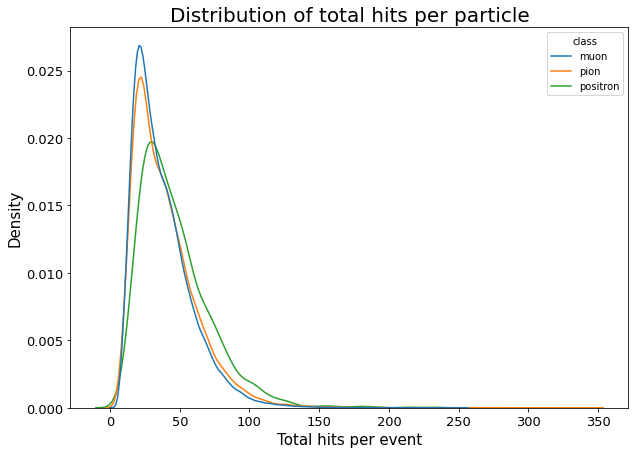

In [33]:
plt.figure(figsize=(10, 7))
sns.kdeplot(hits_df["total_hits"], hue=hits_df["class"], common_norm=False, palette="tab10")
plt.title("Distribution of total hits per particle", fontsize=20)
plt.xlabel("Total hits per event", fontsize=15);
plt.ylabel("Density", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

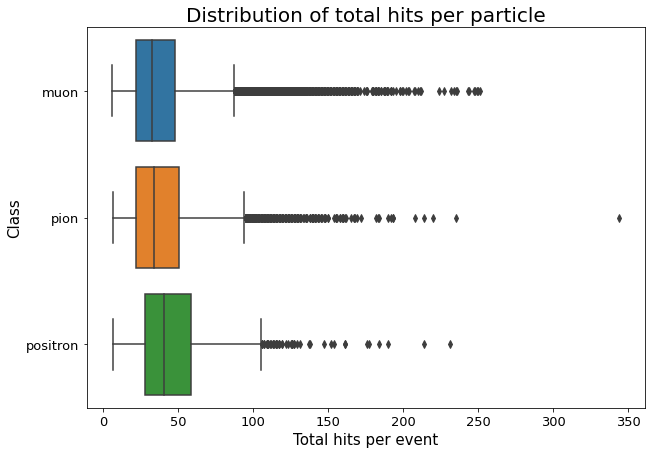

In [34]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=hits_df, x="total_hits", y="class", palette="tab10")
plt.title("Distribution of total hits per particle", fontsize=20)
plt.xlabel("Total hits per event", fontsize=15);
plt.ylabel("Class", fontsize=15);
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

## Total hits per particle by momentum bin

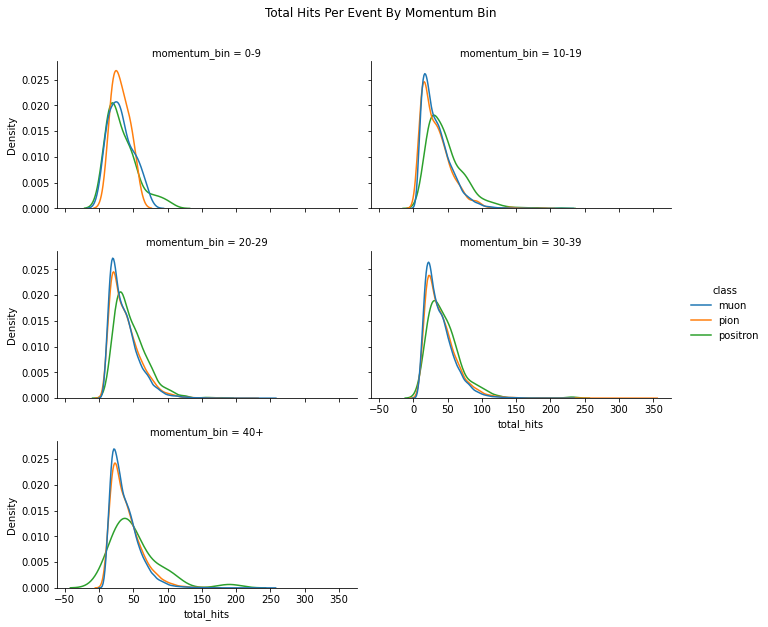

In [35]:
g = sns.displot(
    data=hits_df,
    x="total_hits",
    kind="kde",
    hue="class",
    col="momentum_bin",
    common_norm=False,
    col_wrap=2,
    height=2.75,
    aspect=1.75
)

g.fig.suptitle("Total Hits Per Event By Momentum Bin", y=1.05)
plt.show()

## Distribution of hit time deltas (hit - chod) for 10 events for each particle

In [36]:
def get_time_delta_plots(samples, suptitle=None):
    total_plots = len(samples)
    cols = 5
    rows = total_plots // cols
    rows += total_plots % cols
    position = range(1, total_plots+1)
    
    fig = plt.figure(1, figsize=(17, 13))
    color = None

    for i, k in zip(samples.index, range(total_plots)):
        hit_info = get_hit_info_df(f, samples, i)

        label = hit_info["class"].unique()[0]
        momentum = samples.loc[i]['track_momentum']
        title = f"Event {i}: {label} \n Momentum: {momentum:2f}"

        if label == "muon":
            color = "#1f77b4"
        elif label == "pion":
            color = "#ff7f0e"
        elif label == "positron":
            color = "#2ca02c"

        ax = fig.add_subplot(rows, cols, position[k])
        sns.kdeplot(hit_info["chod_delta"], ax=ax, color=color)
        ax.set_title(title)
        ax.set_xlabel("Time delta")
    
    if suptitle:
        fig.suptitle(suptitle, y=1.02, fontsize=25)
    
    plt.tight_layout()
    plt.show()

<div class="alert alert-warning">
Below the hit times for 10 events for each particle are plotted for each momentum bin.
    
We can see that regardless of momentum, the distribtions are almost always bimodal.
</div>

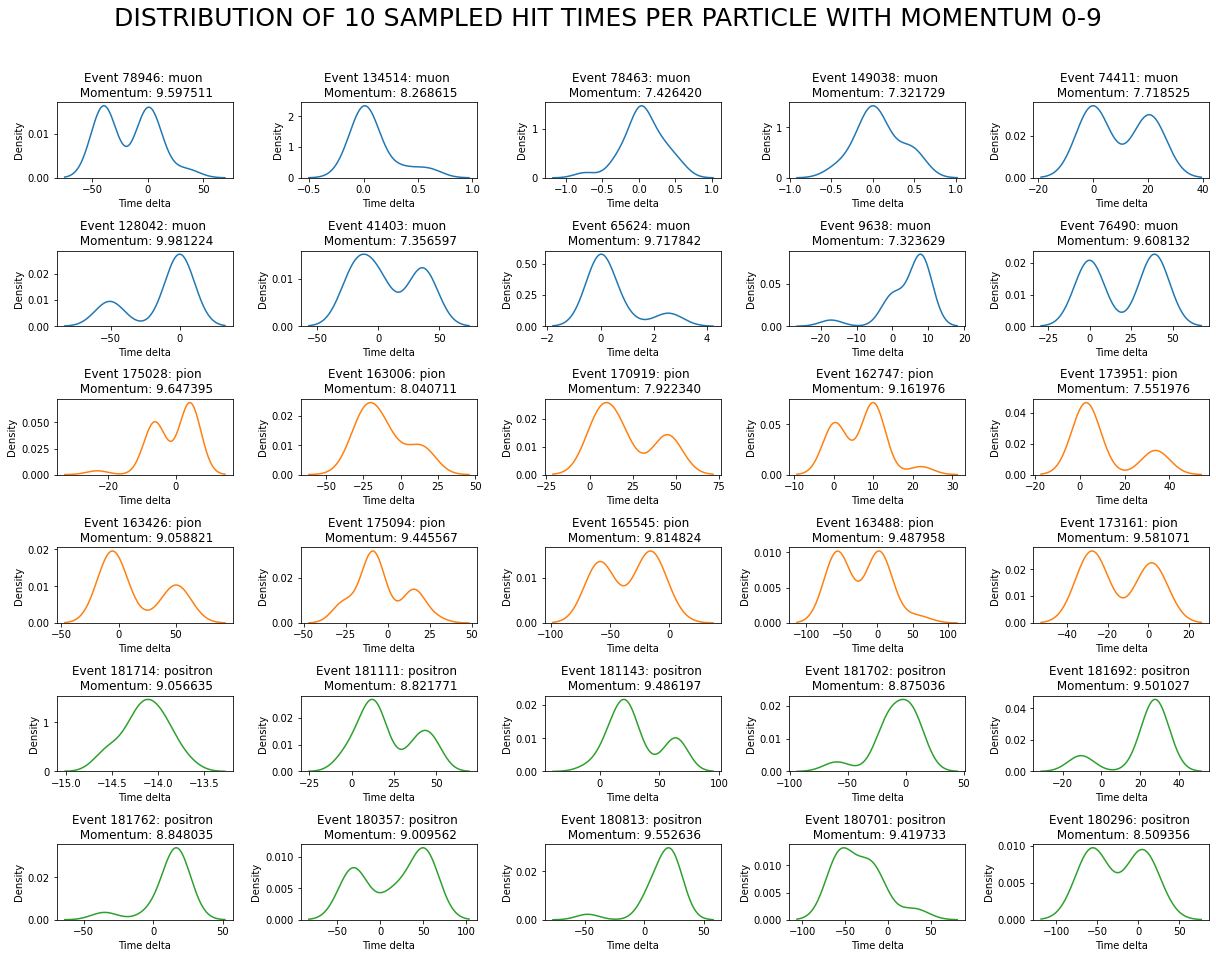

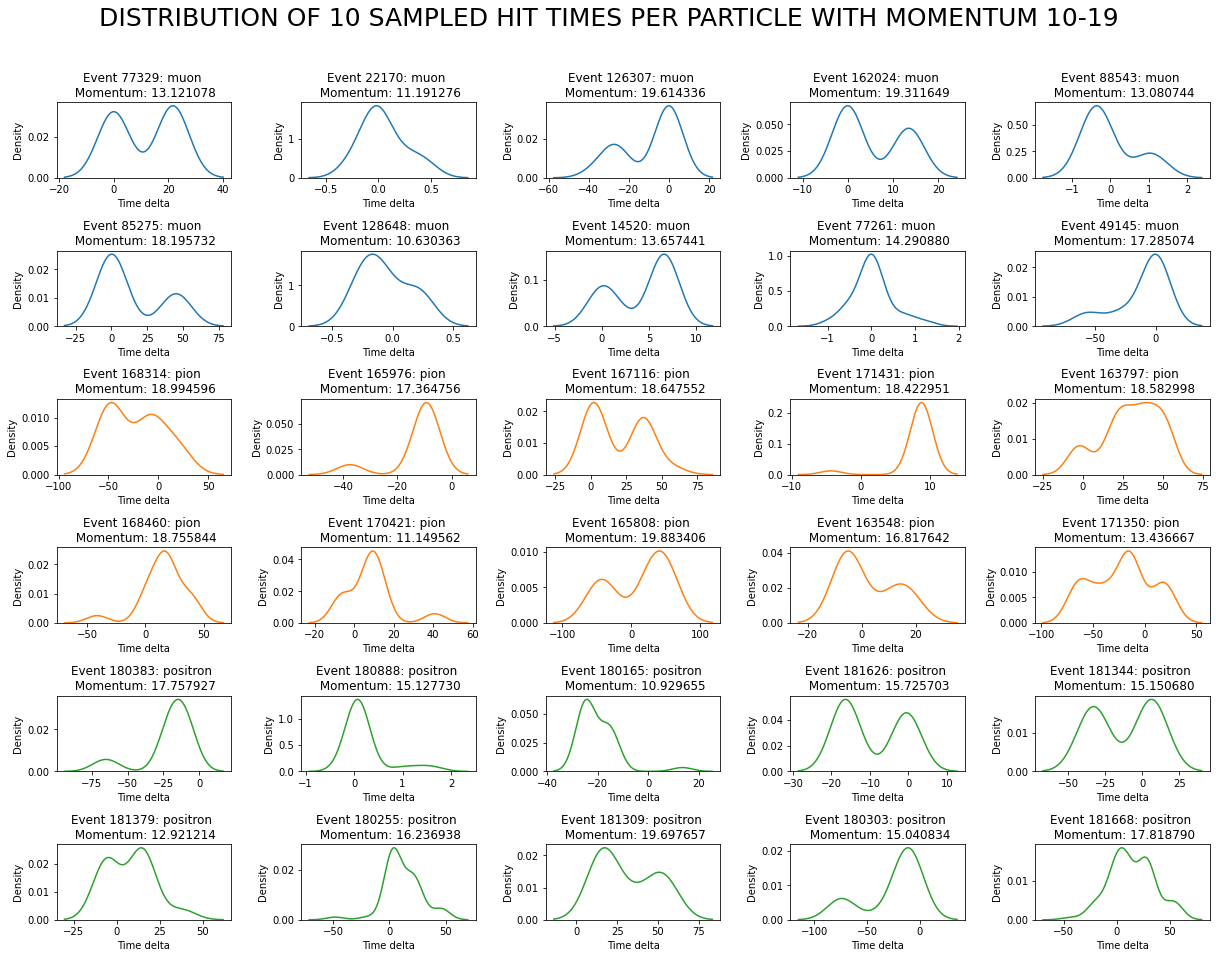

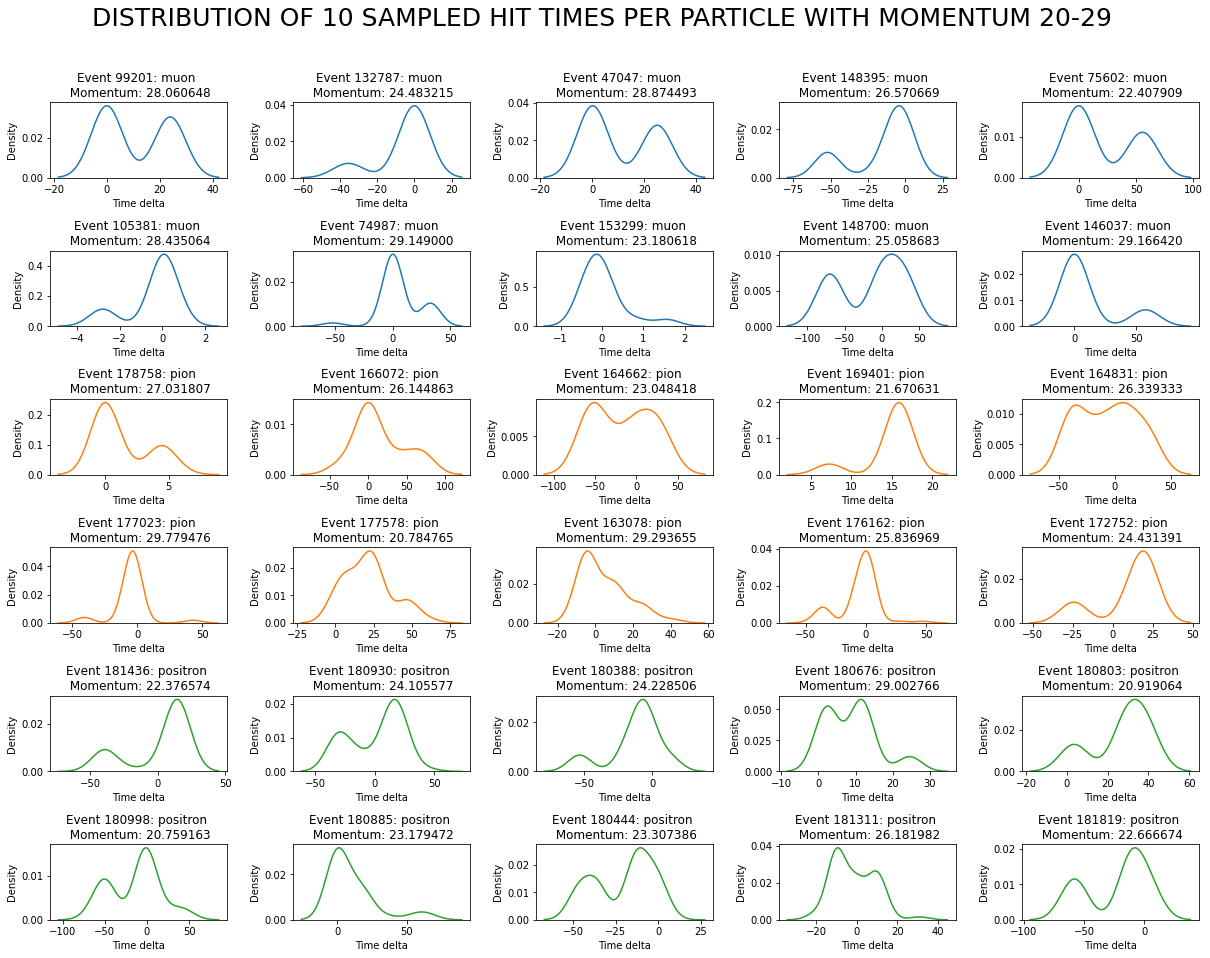

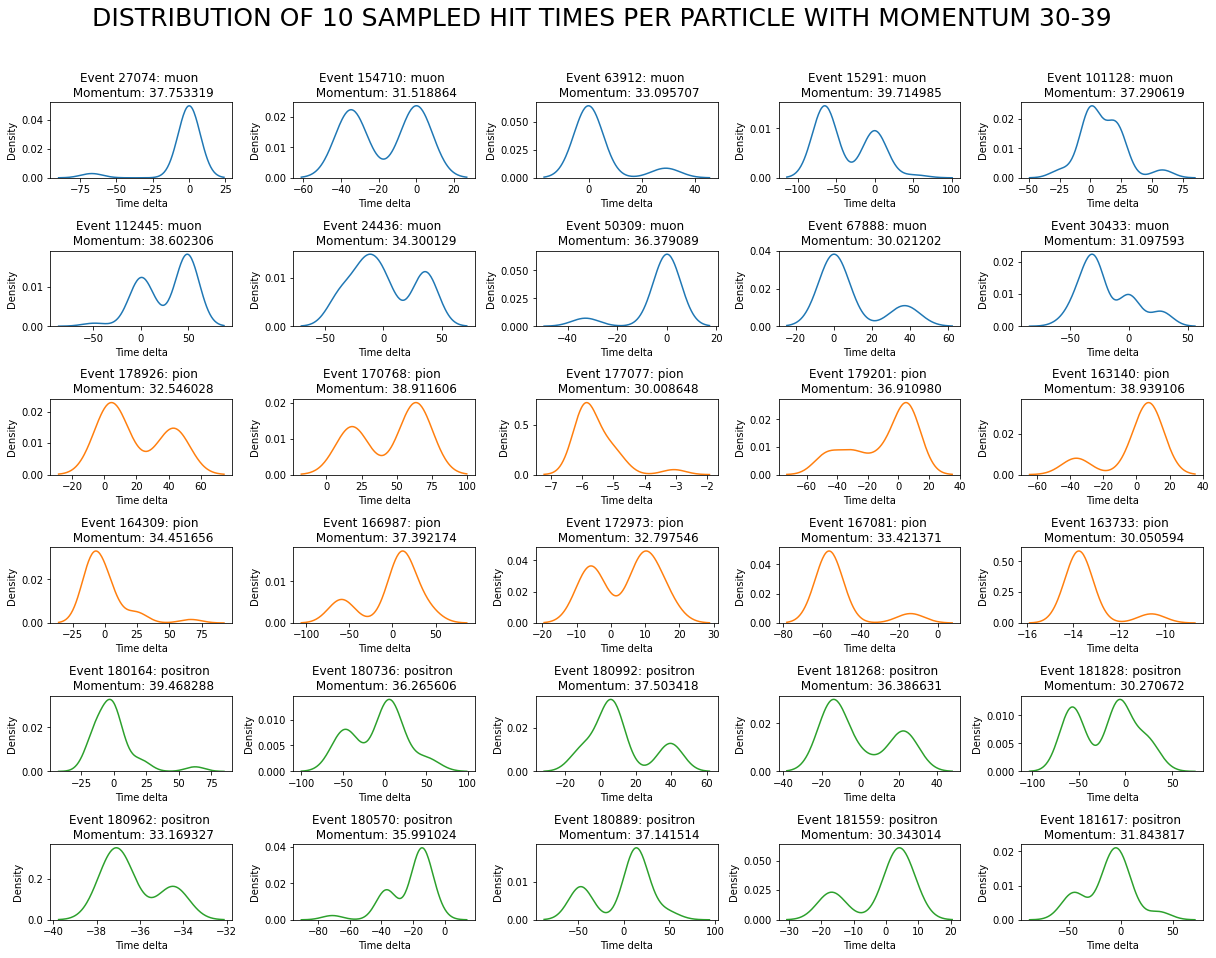

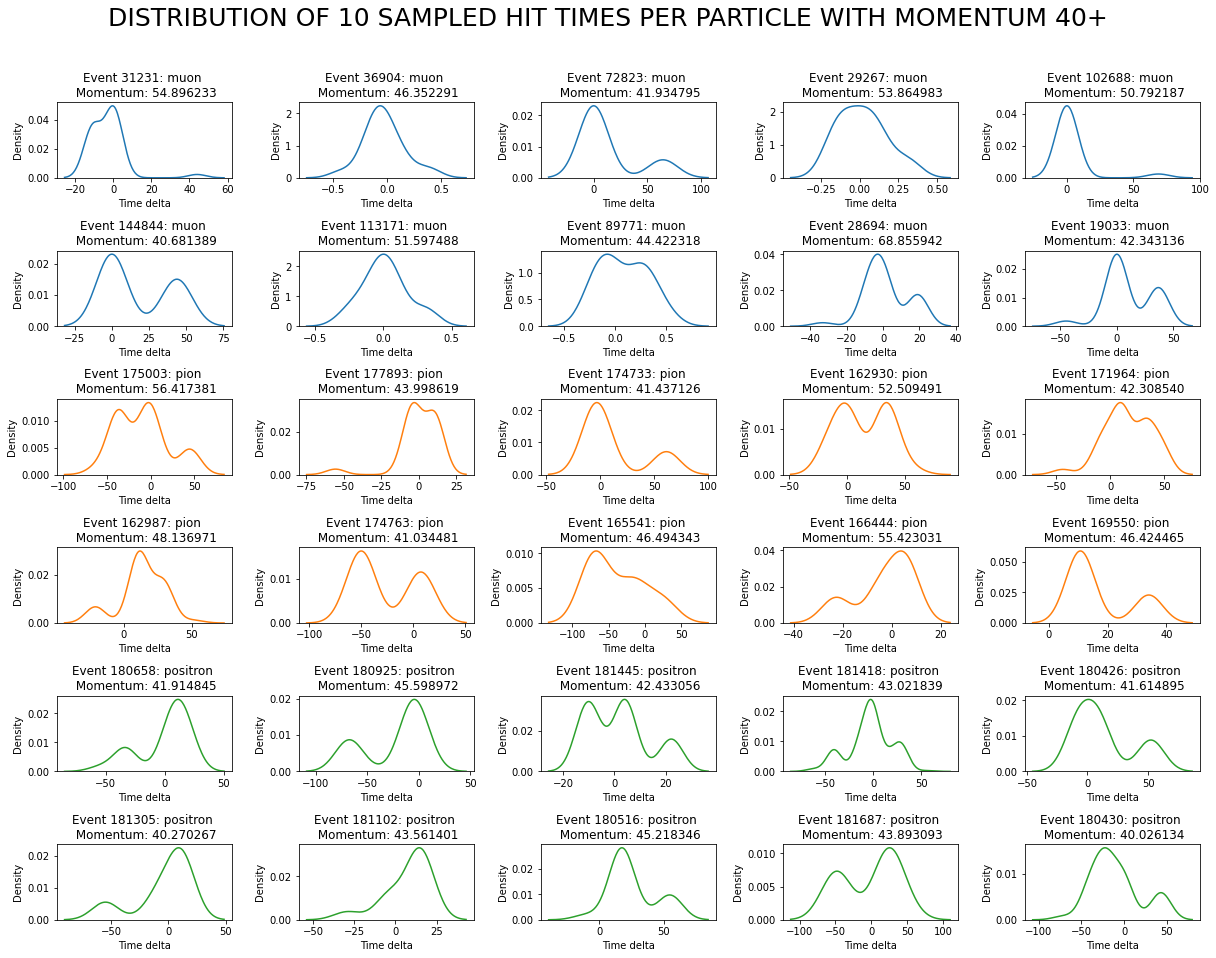

In [37]:
n = 10
seed = 42

for momentum_bin in momentum_bins:
    samples = get_class_samples(hits_df, n, seed, momentum_bin)
    suptitle = f"DISTRIBUTION OF {n} SAMPLED HIT TIMES PER PARTICLE WITH MOMENTUM {momentum_bin}"
    get_time_delta_plots(samples, suptitle)

## Ring plots

<div class="alert alert-warning">
Something is up with the alignment of the ring centre...
</div>

In [38]:
def plot_rings(samples):
    for i in samples.index:
        momentum = samples.loc[i]["track_momentum"]
        radius = samples.loc[i]["ring_radius"]
        x, y = samples.loc[i]["ring_centre_pos_x"], samples.loc[i]["ring_centre_pos_y"]
        hit_info = get_hit_info_df(f, samples, i)
        label = hit_info["class"].unique()[0]
        title = f"""
        Event {i}: {label}
        Momentum: {momentum:2f}
        Centre: ({x:2f}, {y:2f})
        Radius: {radius:2f}
        """

        fig = plt.figure(figsize=(10, 10))
        ax = fig.subplots()
        ax.set_aspect('equal')
        ax.set_xlim(-350,350) # mm
        ax.set_ylim(-350,350) # mm
        ax.set_xlabel('X (mm)')
        ax.set_ylabel('Y (mm)')
        ax.set_title(title)

        draw_pmt_pos(ax, position_map)
        plt.scatter(hit_info['x'], hit_info['y'], c=np.power(hit_info["chod_delta"], 2), cmap="plasma")
        cbar = plt.colorbar(shrink=0.8)
        cbar.set_label("Squared Time Delta", fontsize=12)
        plt.clim(0, 50)
        ax.add_artist(plt.Circle((x, y), radius, fill=False,color="red"))
        plt.show()

# Note: The colour bar is the squared (hit time - CHOD time)

# 5 Ring Plots for Each Particle for Momentum bin '0-9'

<div class="alert alert-warning">
Several of these rings have a wonky centre of (999999, 999999)?
</div>

In [39]:
n = 5
seed = 42
momentum_bins

['0-9', '10-19', '20-29', '30-39', '40+']

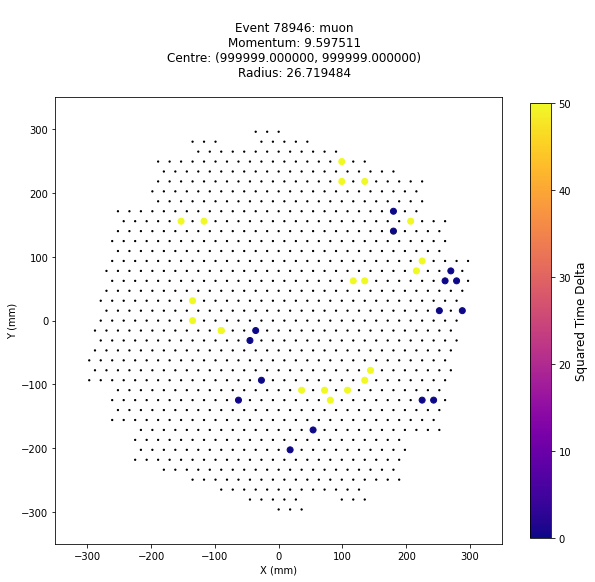

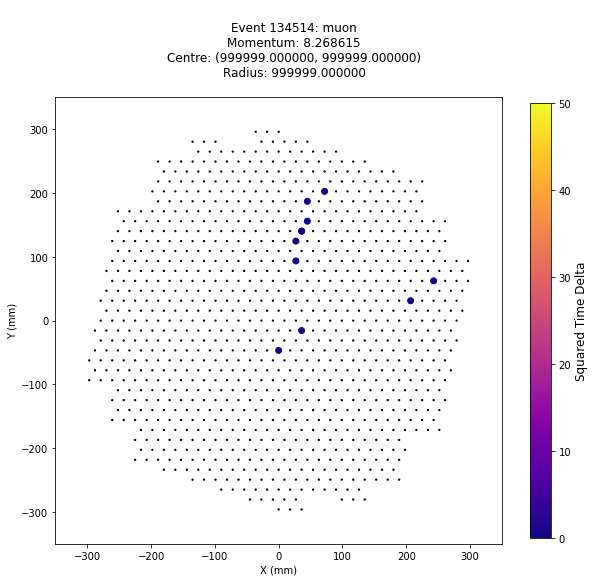

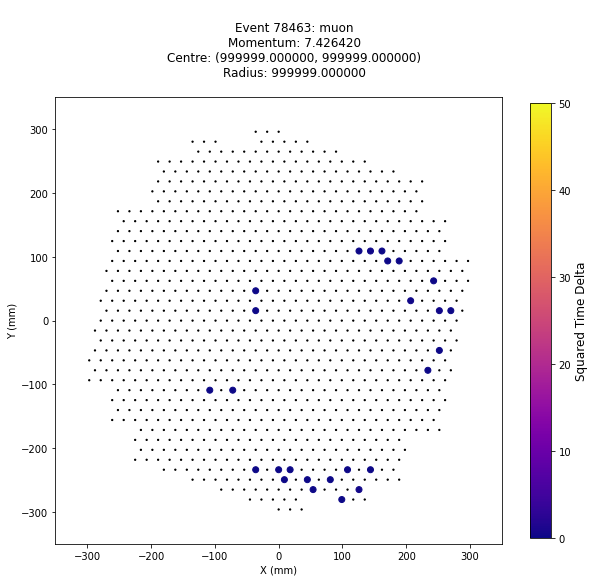

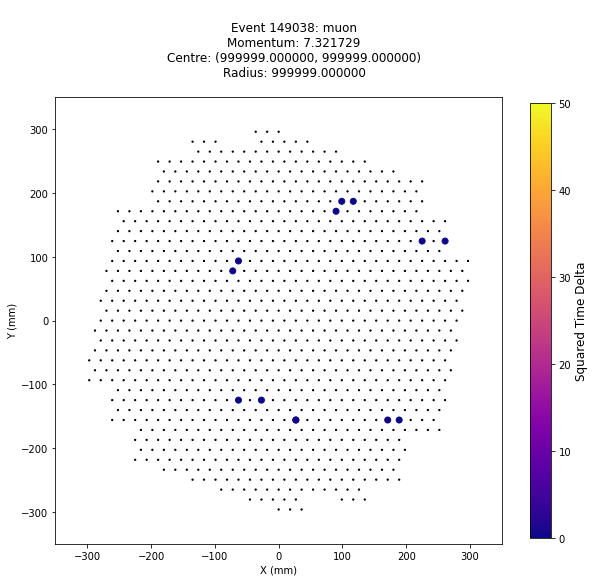

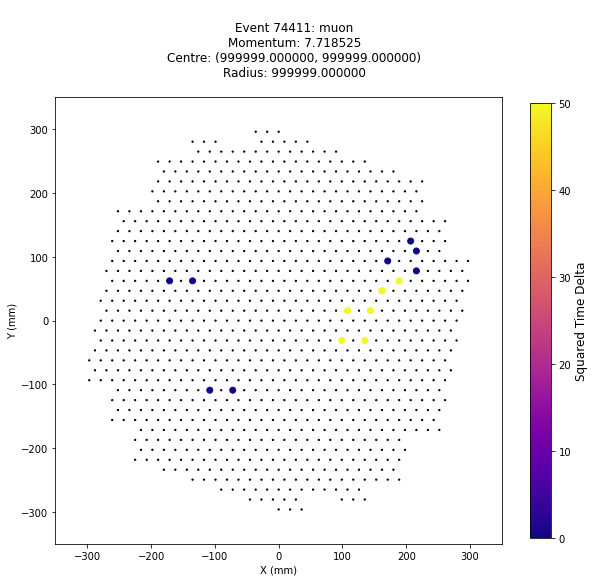

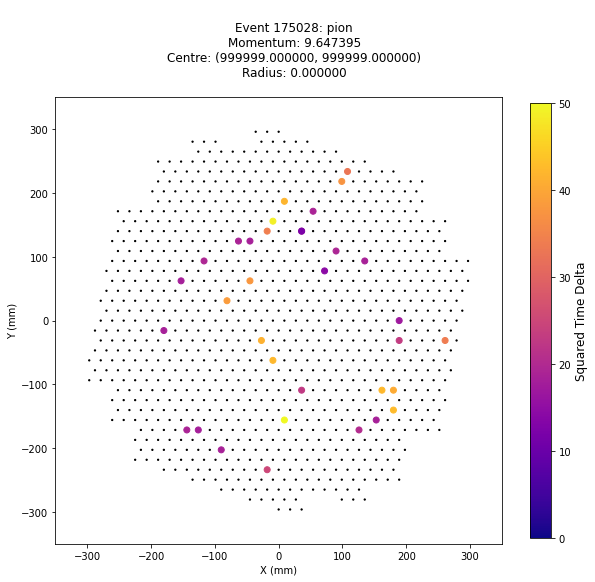

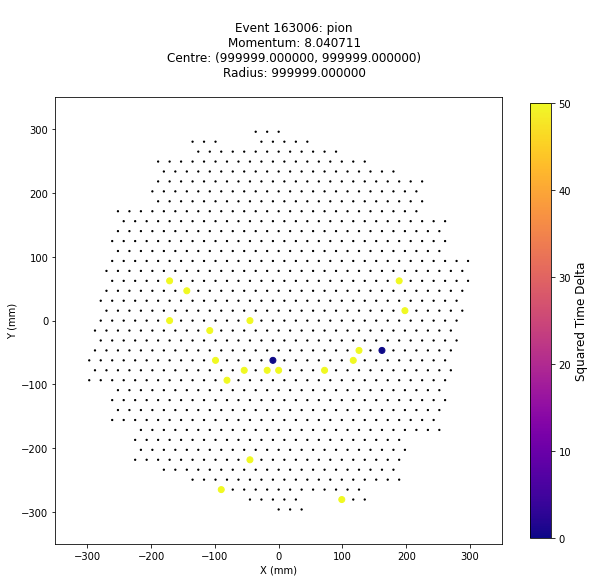

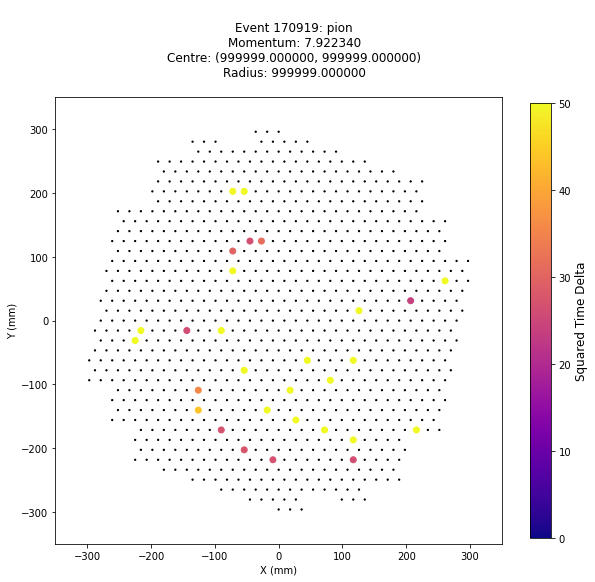

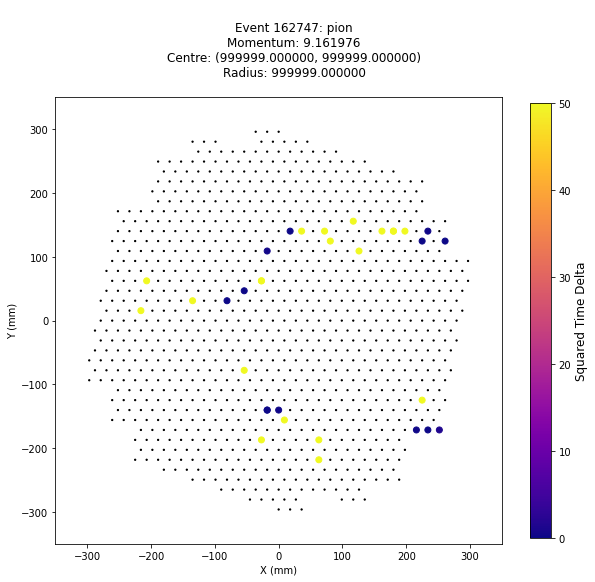

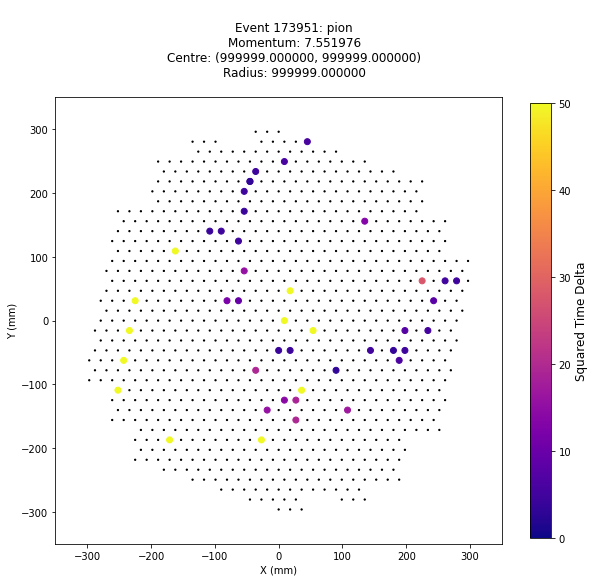

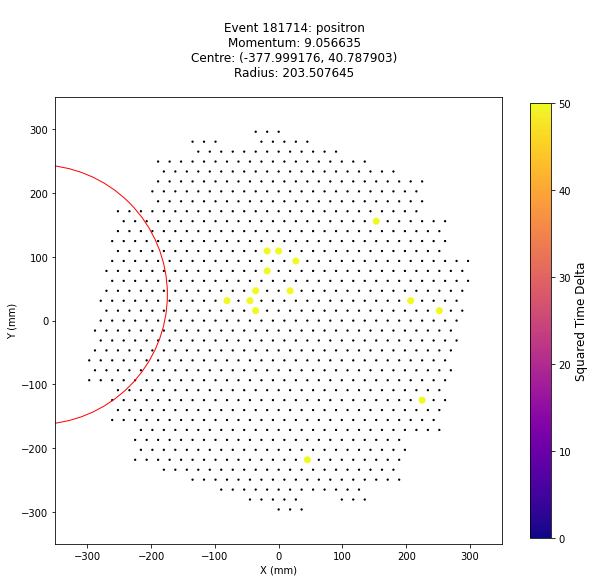

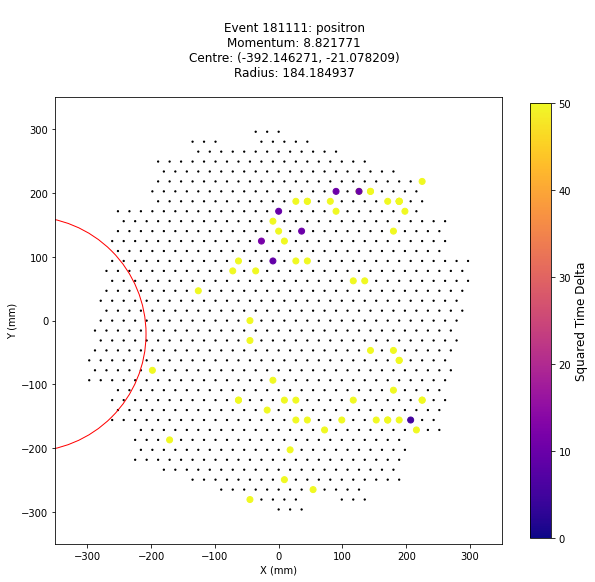

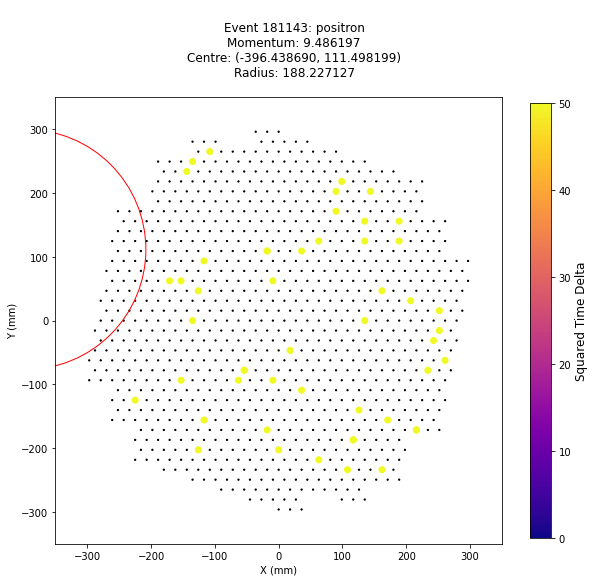

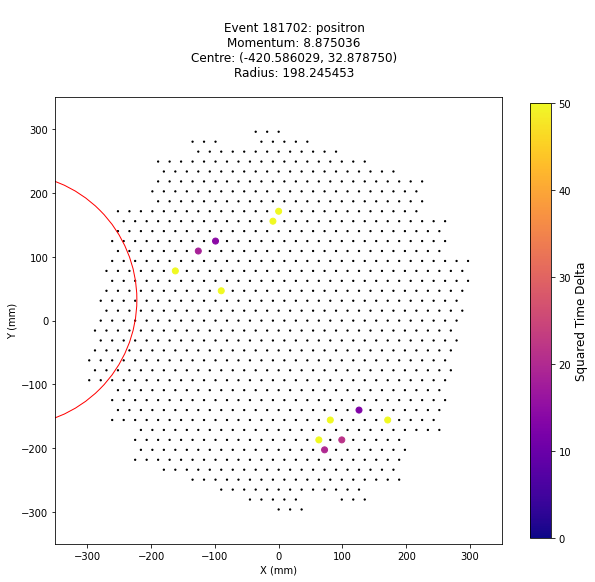

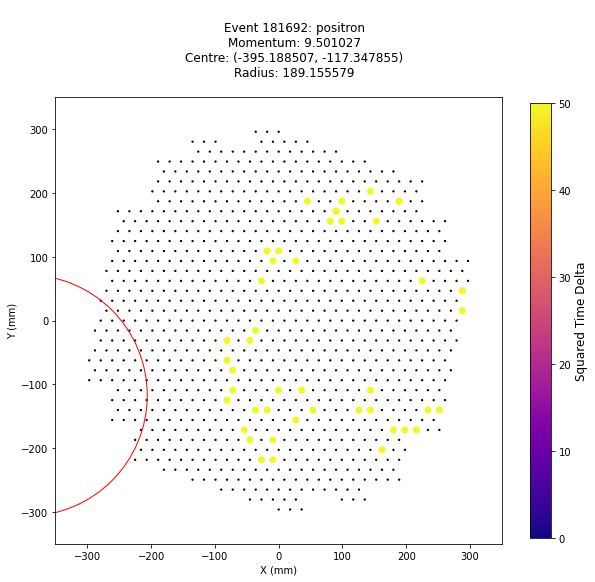

In [40]:
samples = get_class_samples(hits_df, n, seed, '0-9')
plot_rings(samples)

# 5 Ring Plots for Each Particle for Momentum bin '10-19'

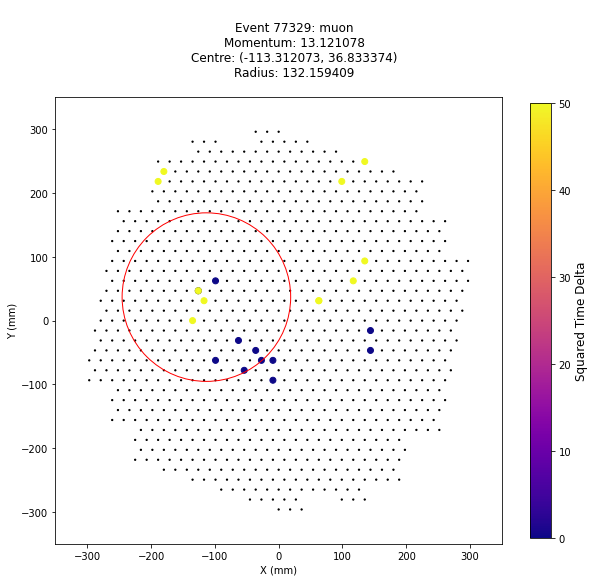

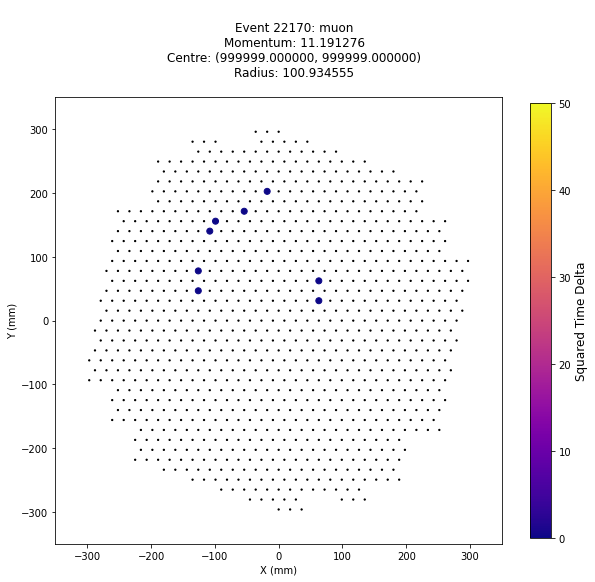

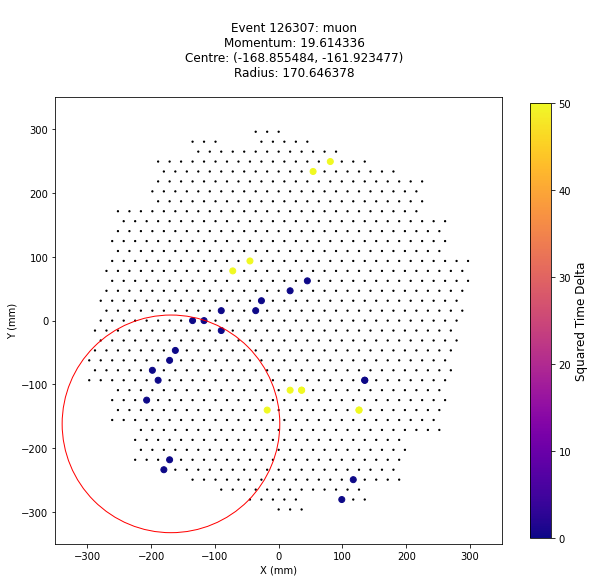

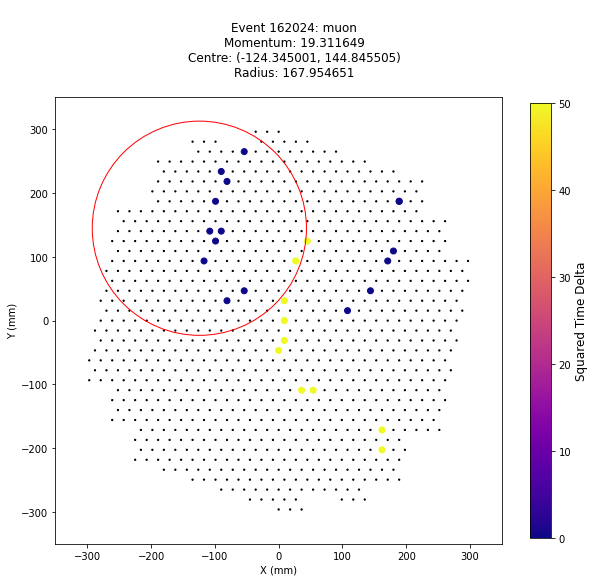

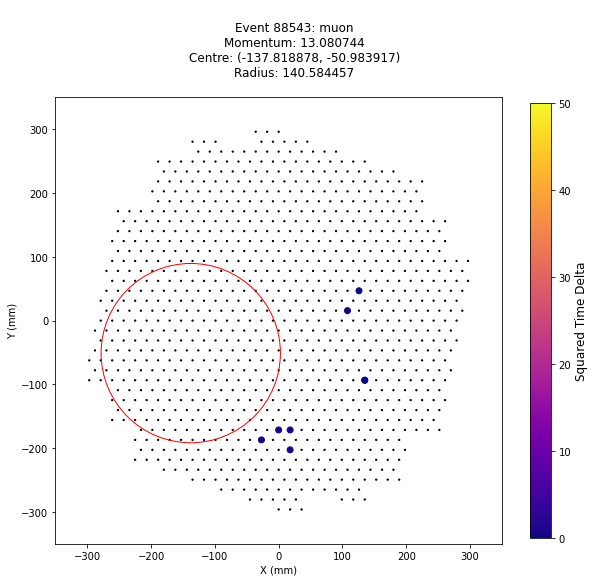

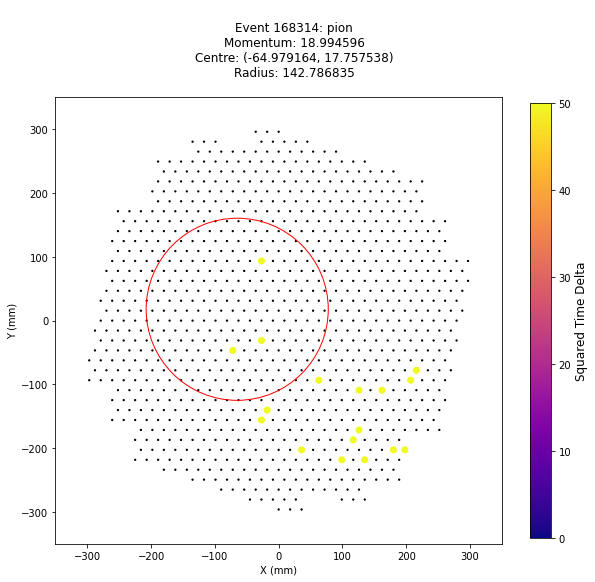

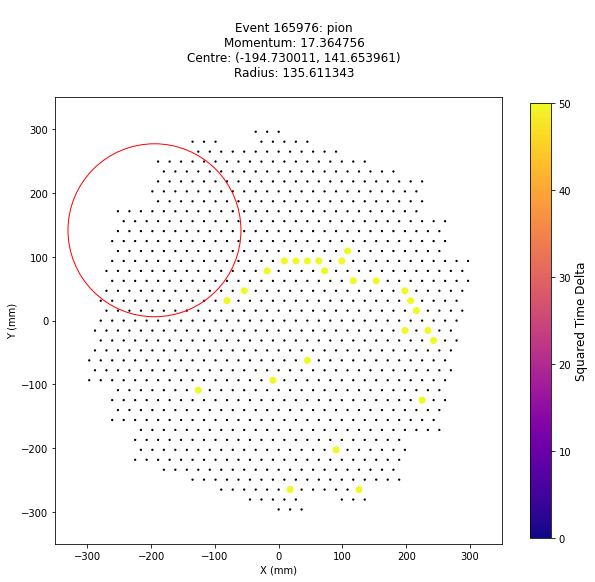

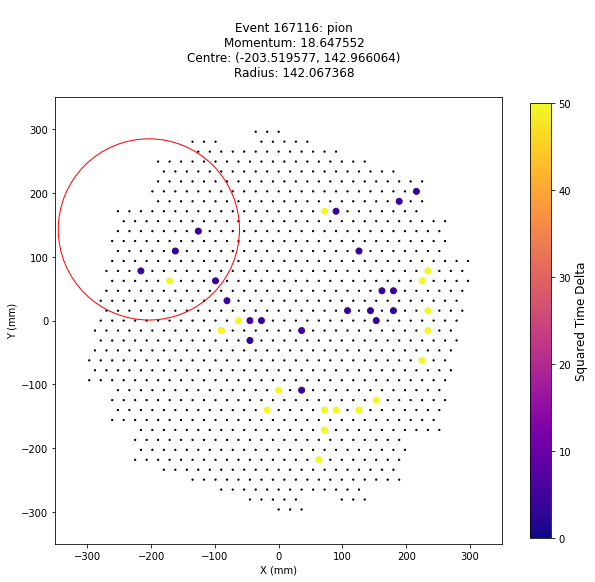

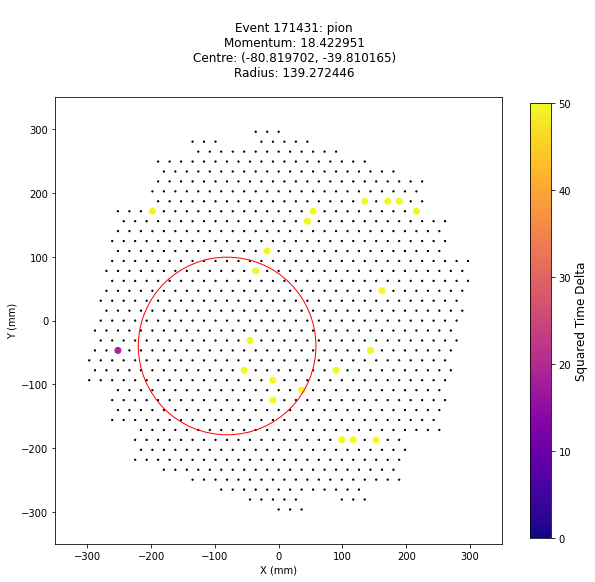

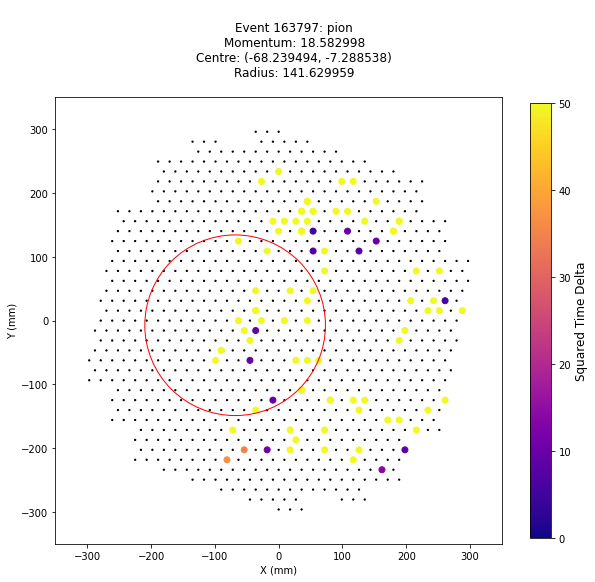

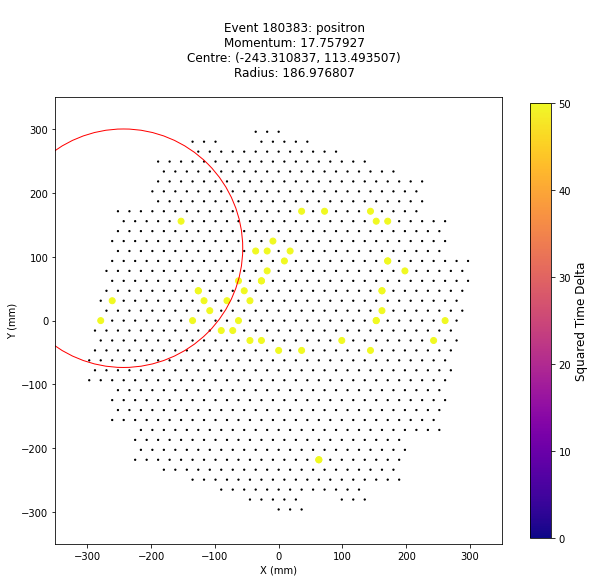

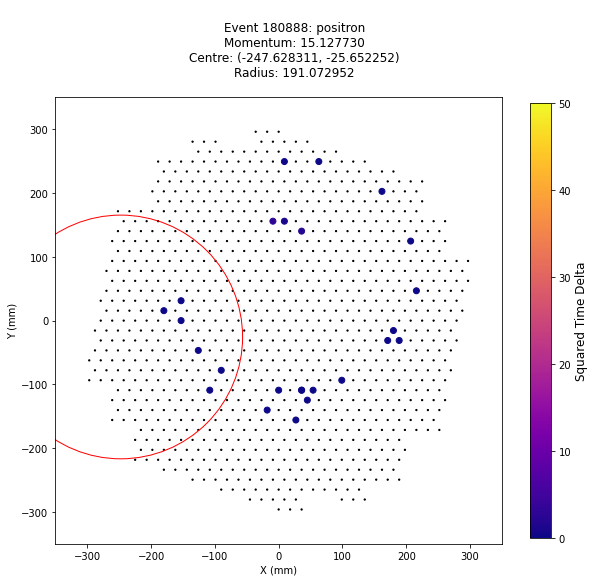

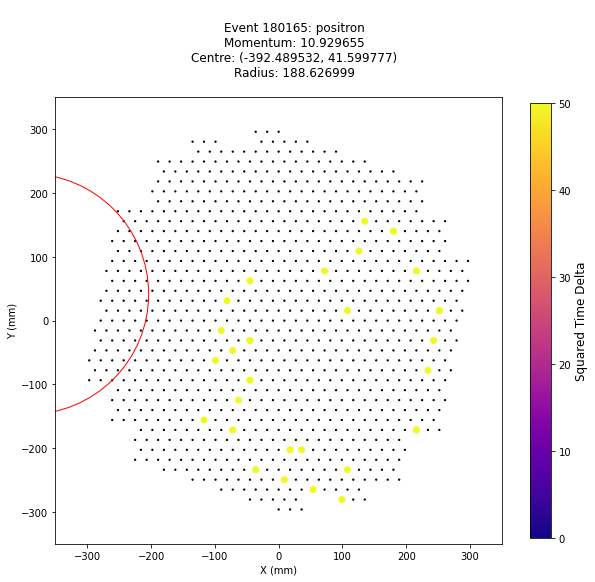

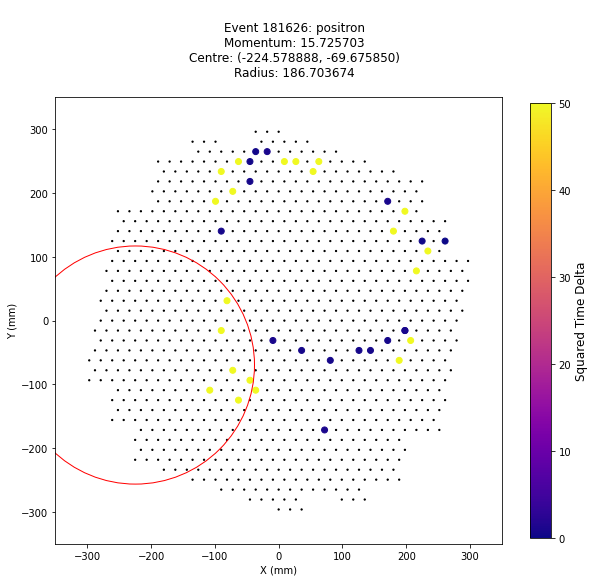

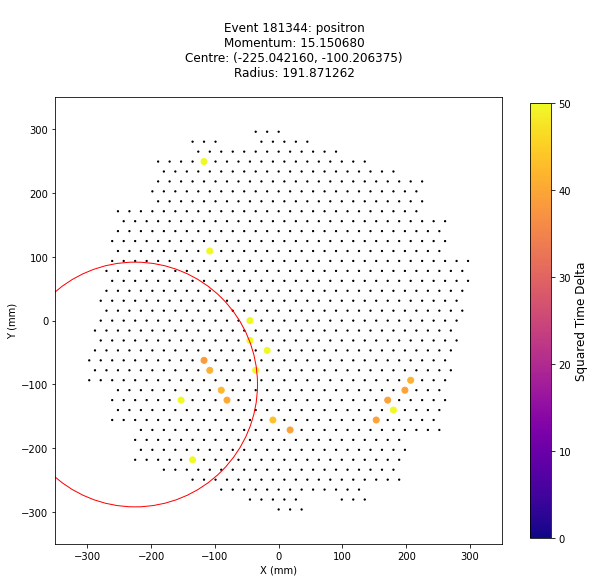

In [41]:
samples = get_class_samples(hits_df, n, seed, '10-19')
plot_rings(samples)

# 5 Ring Plots for Each Particle for Momentum bin '20-29'

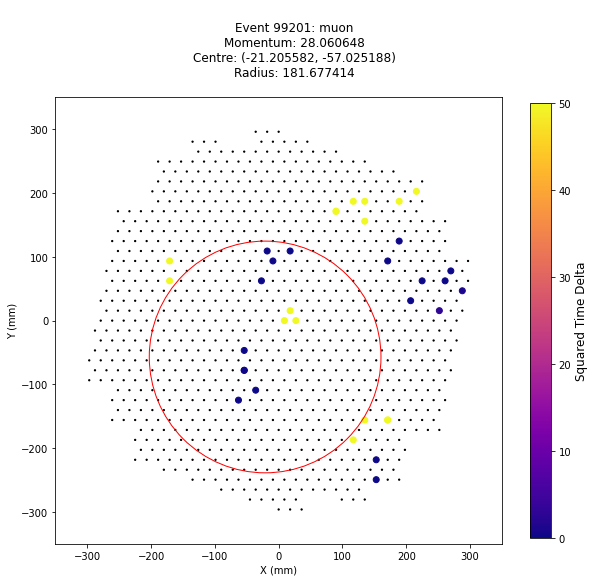

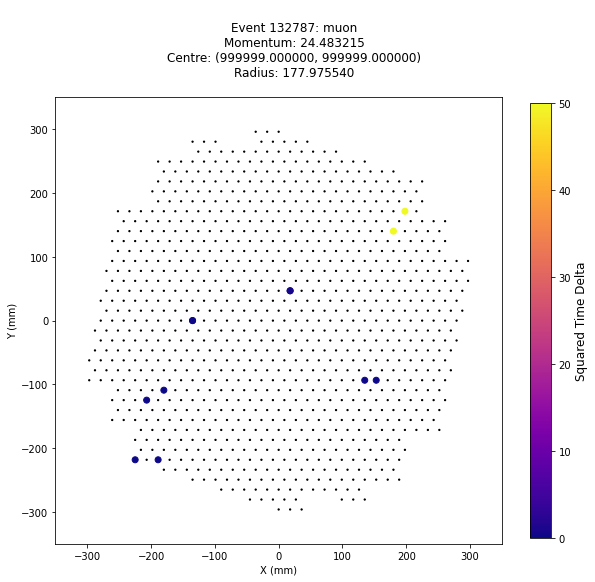

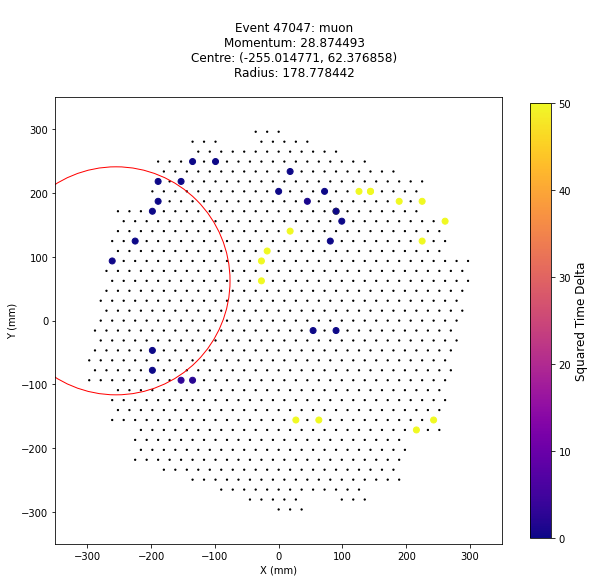

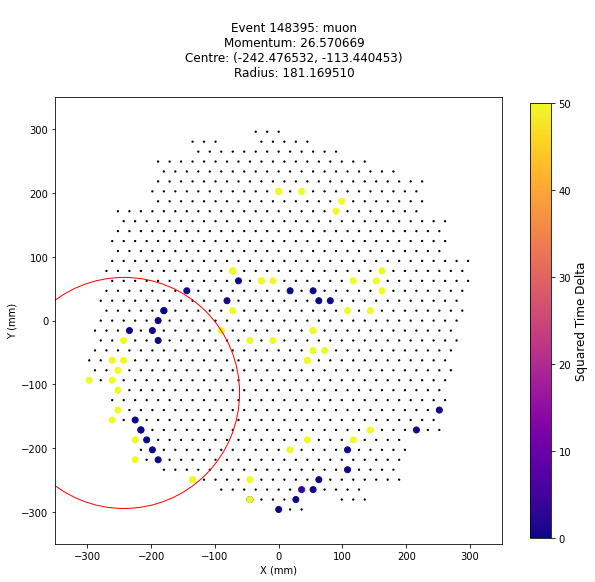

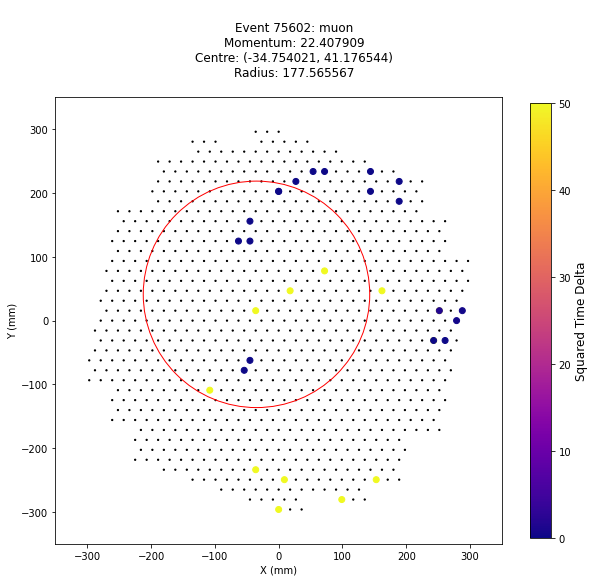

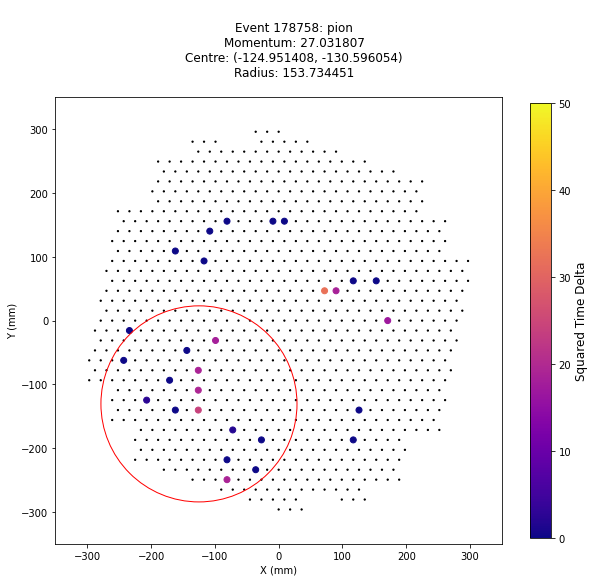

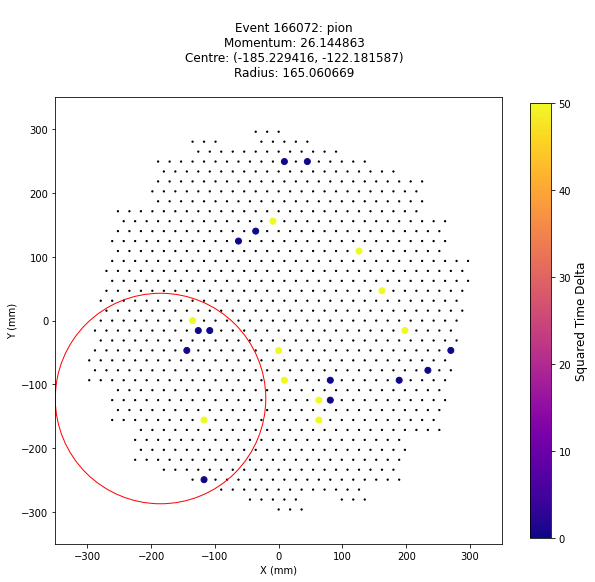

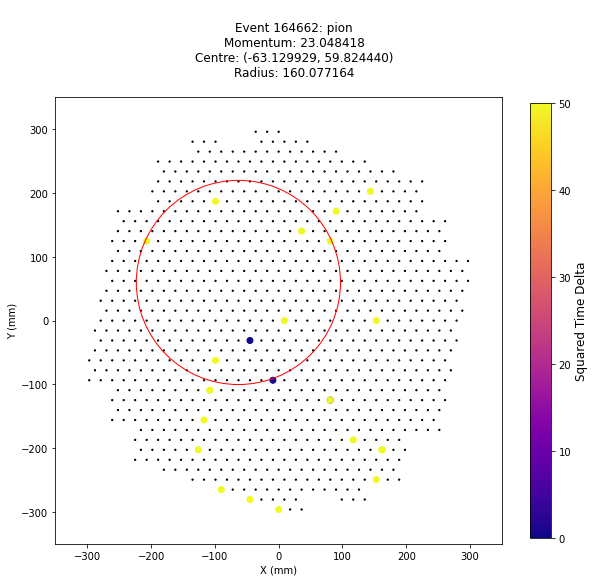

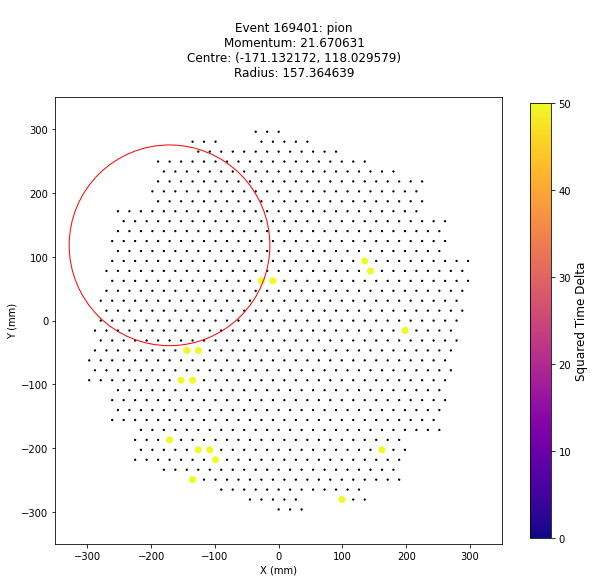

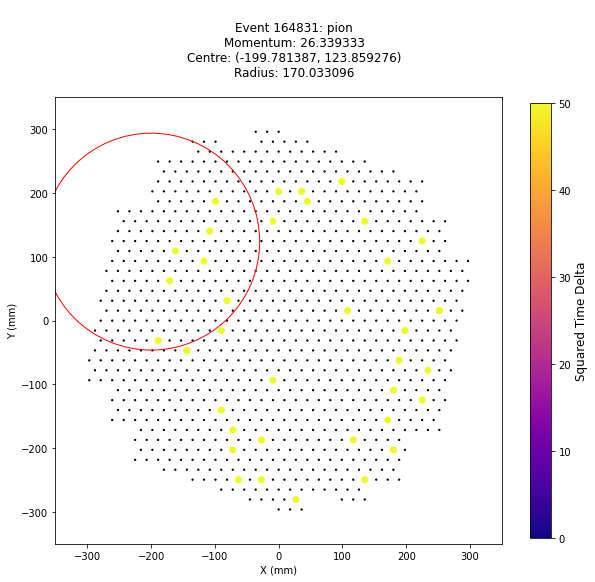

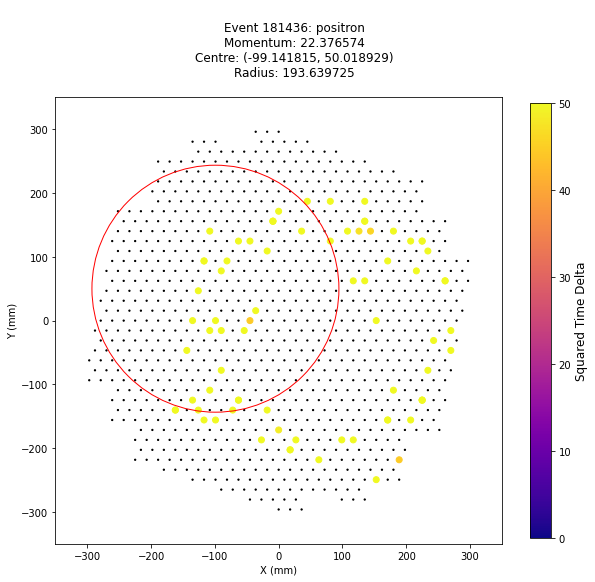

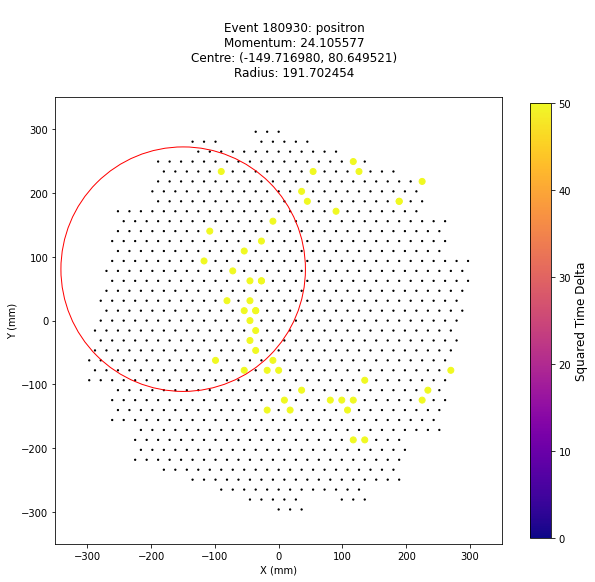

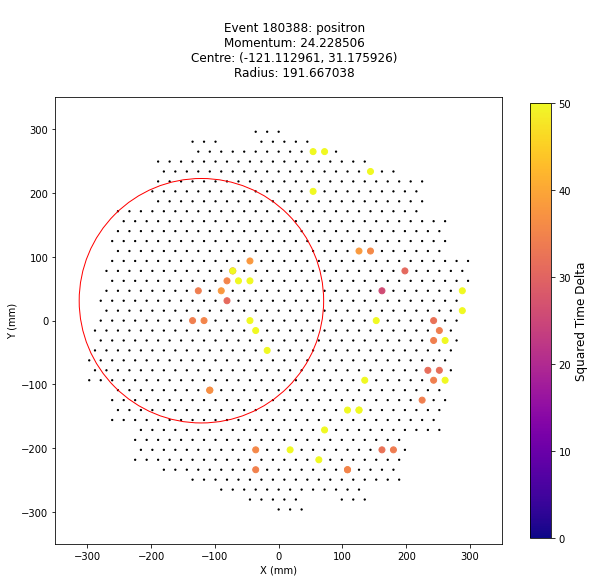

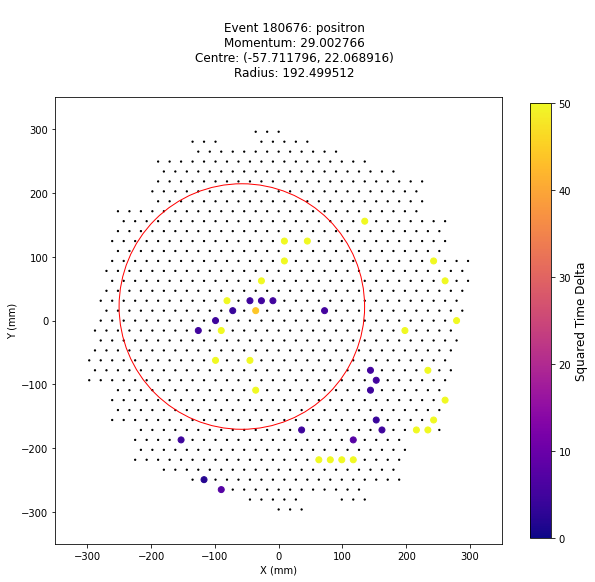

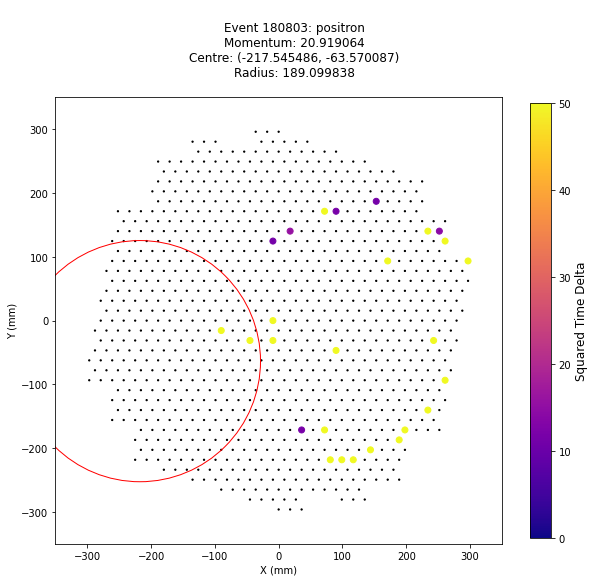

In [42]:
samples = get_class_samples(hits_df, n, seed, '20-29')
plot_rings(samples)

# 5 Ring Plots for Each Particle for Momentum bin '30-39'

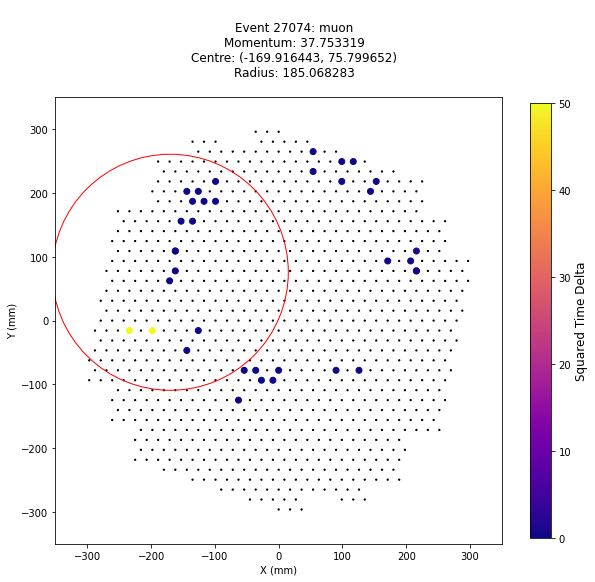

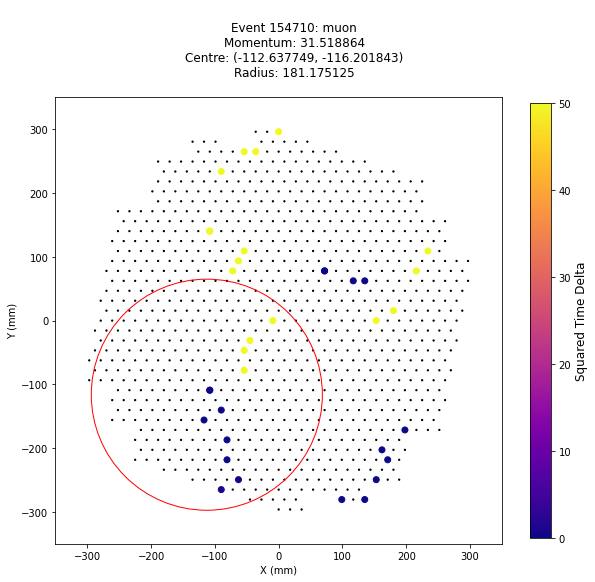

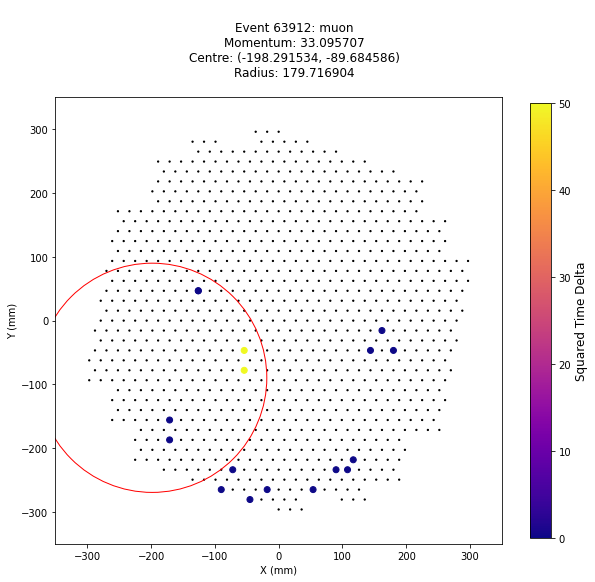

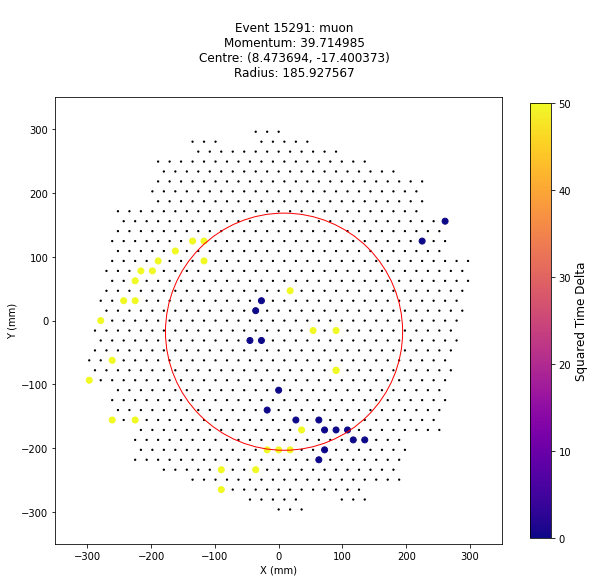

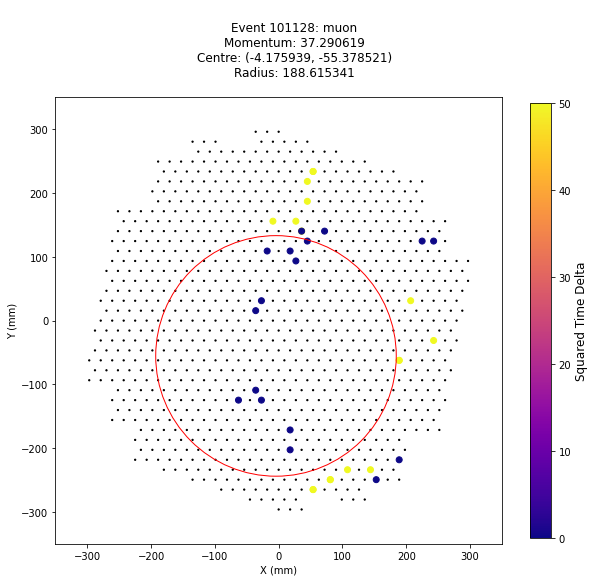

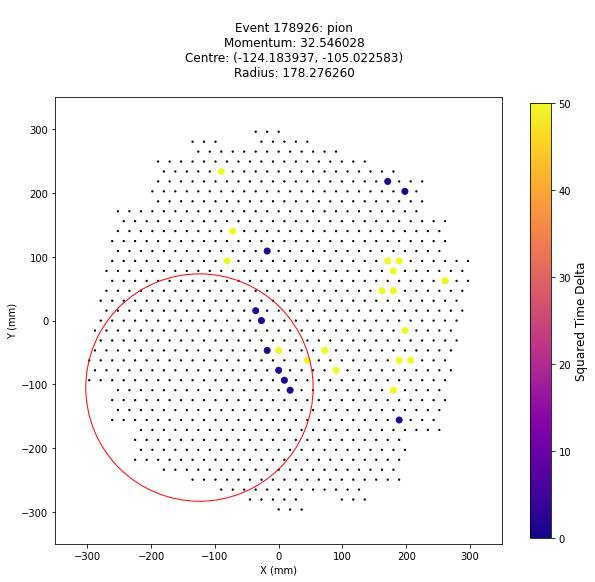

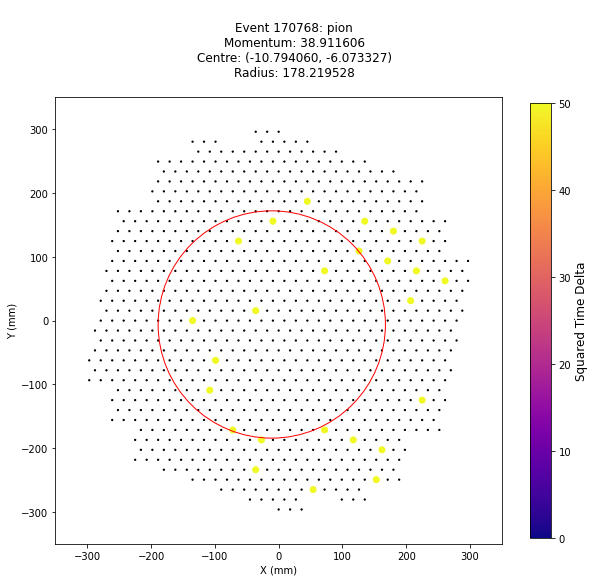

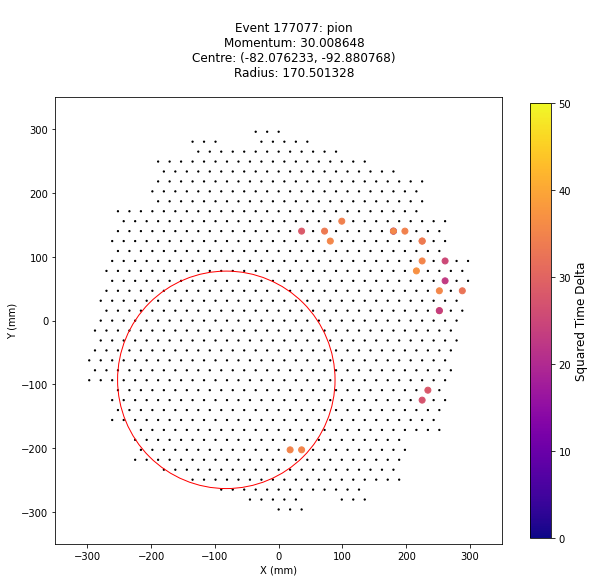

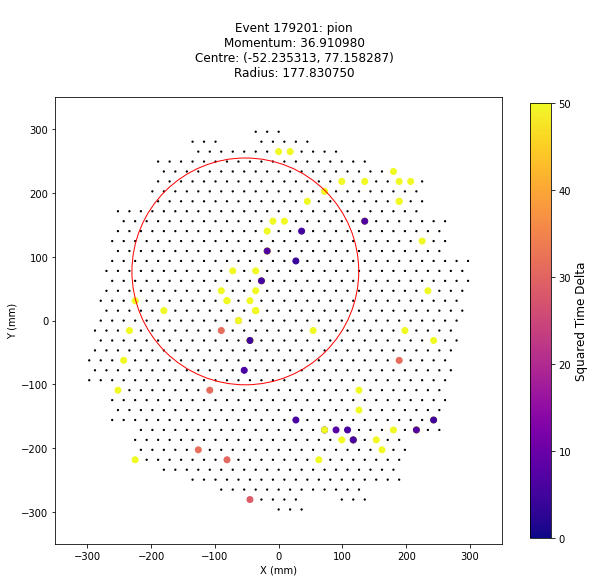

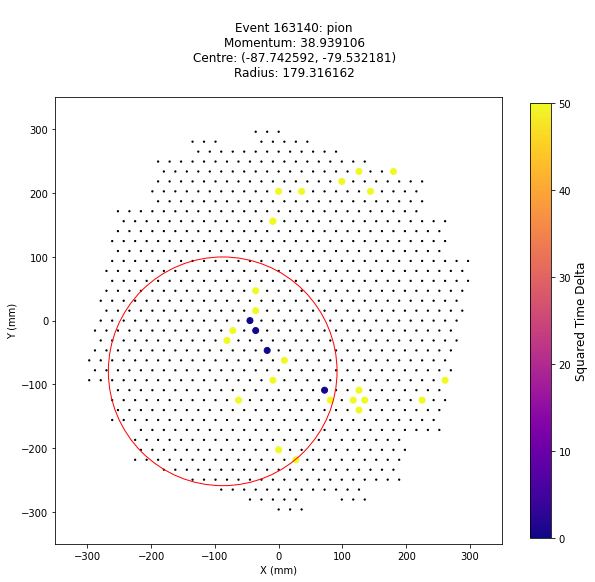

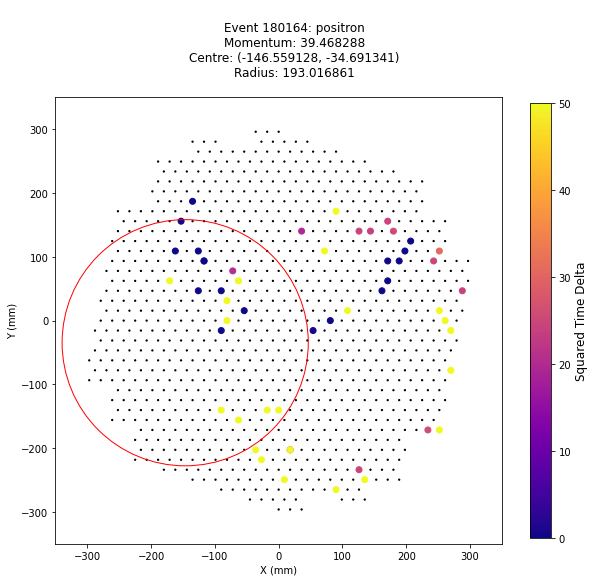

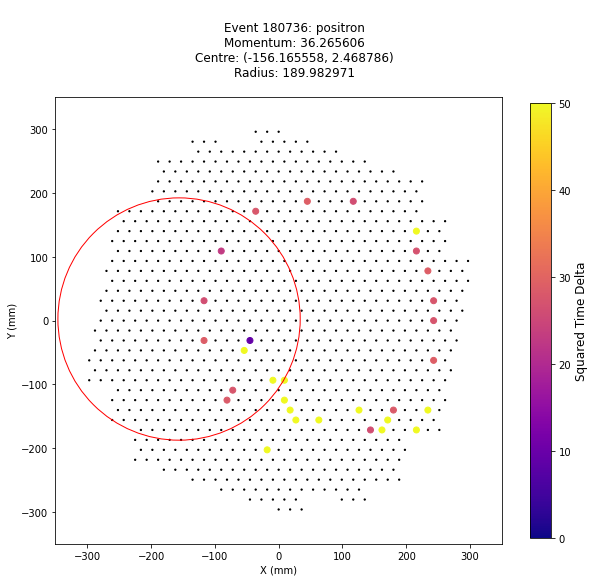

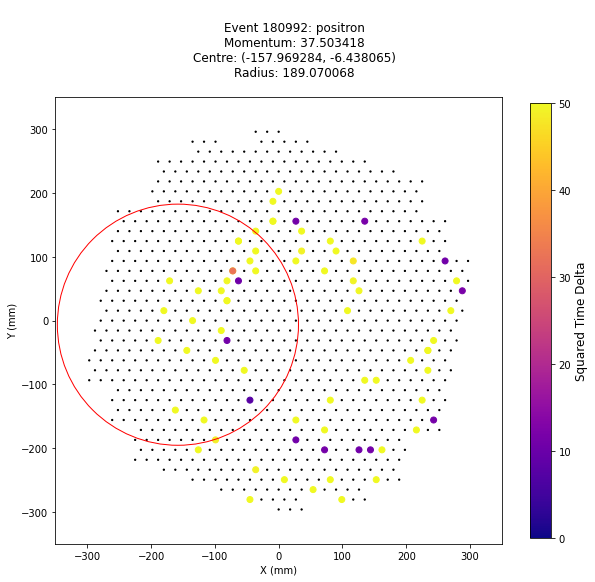

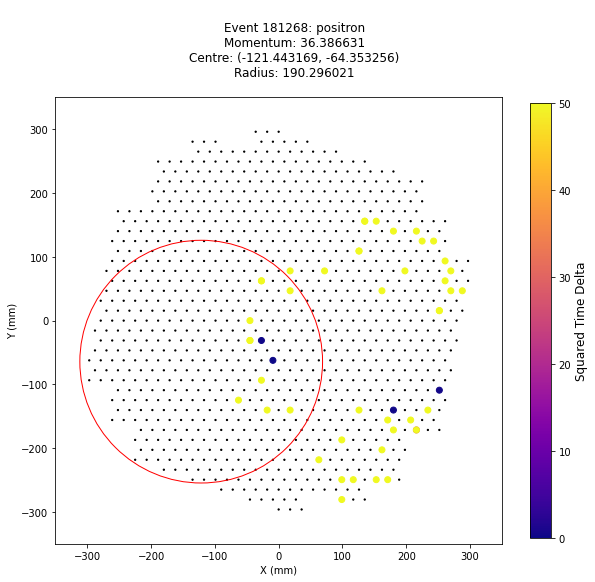

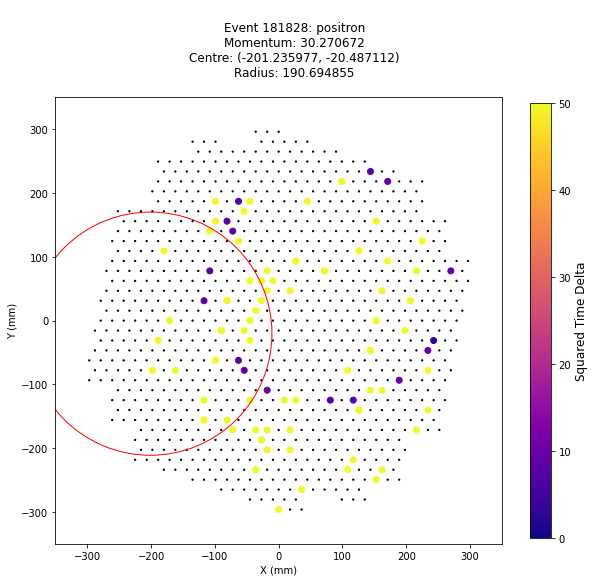

In [43]:
samples = get_class_samples(hits_df, n, seed, '30-39')
plot_rings(samples)

# 5 Ring Plots for Each Particle for Momentum bin '40+'

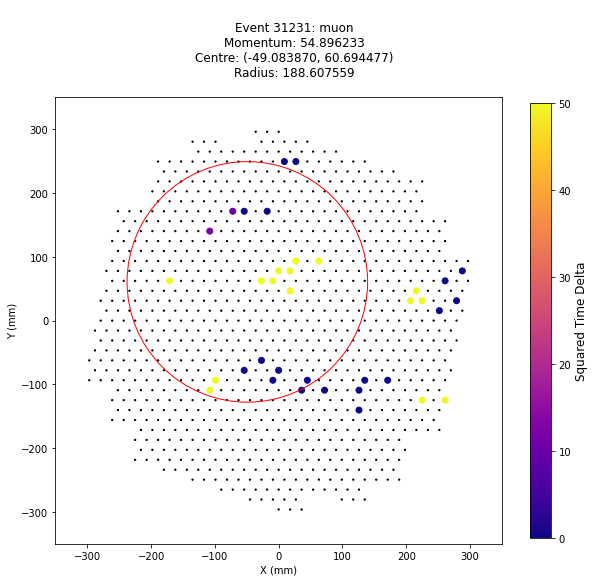

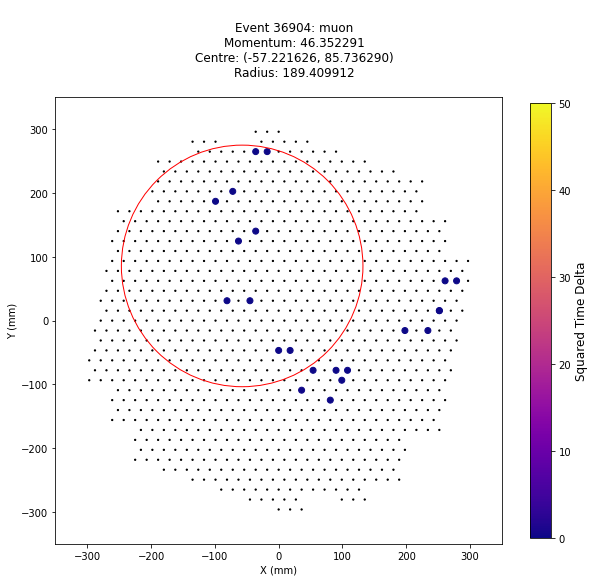

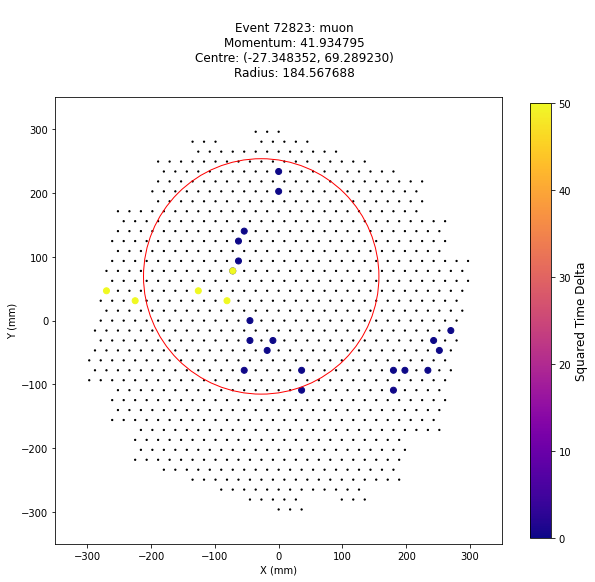

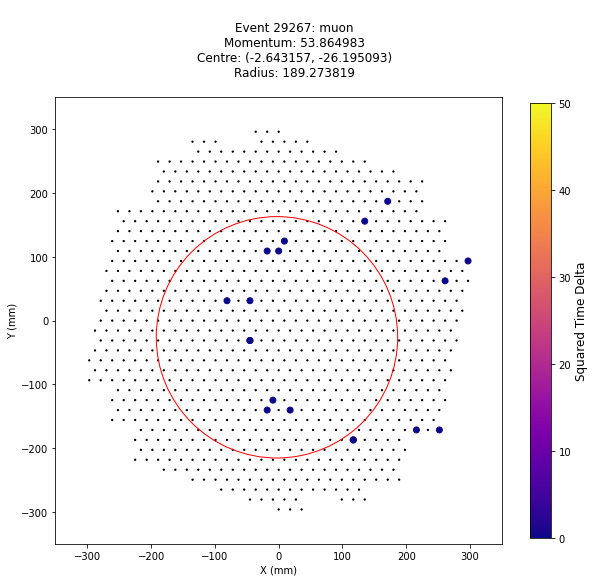

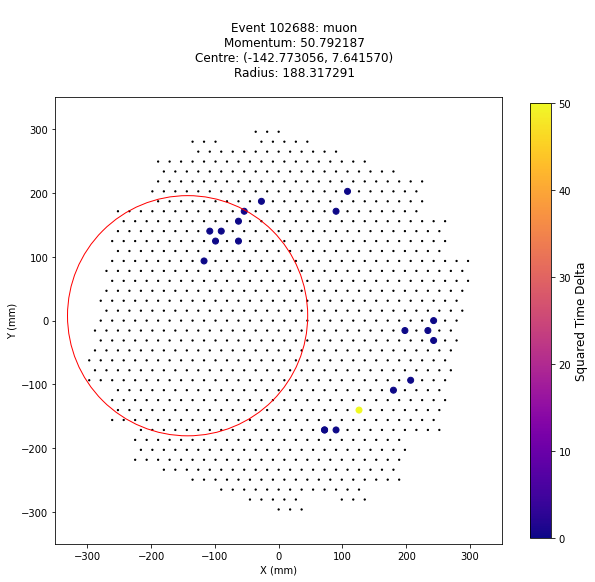

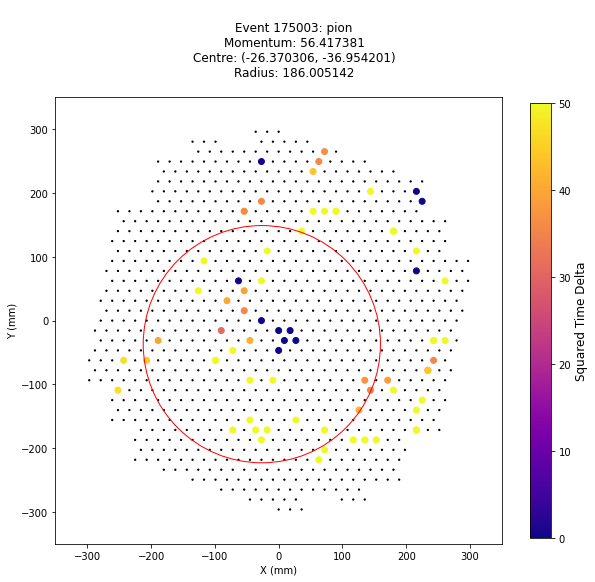

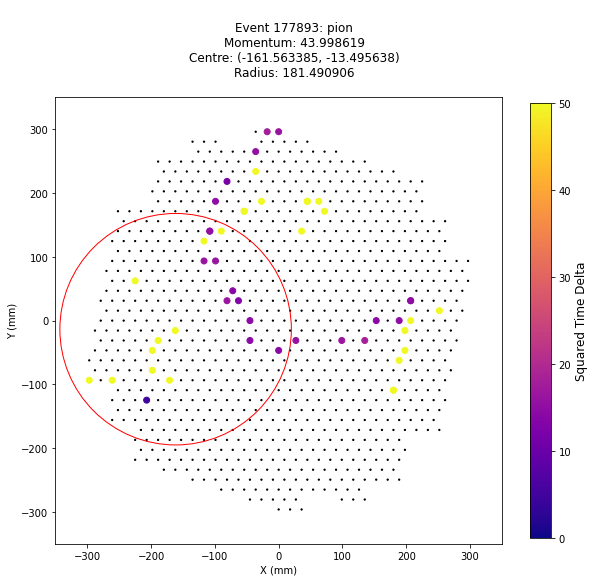

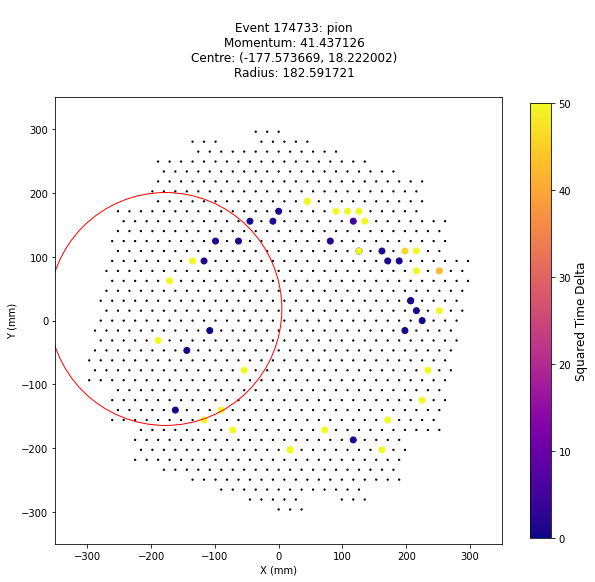

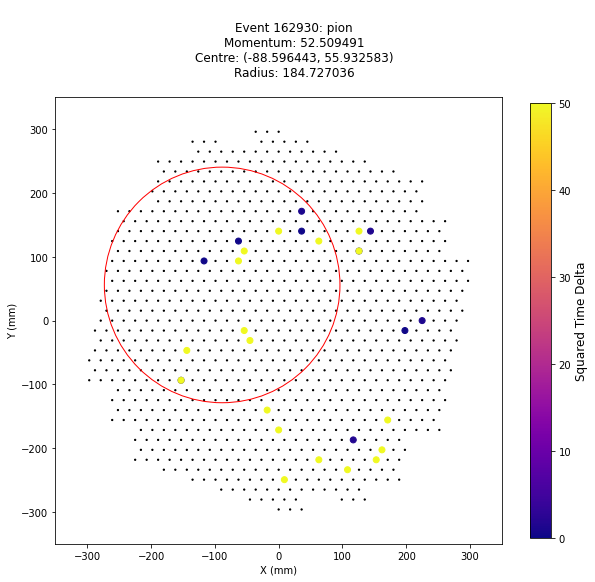

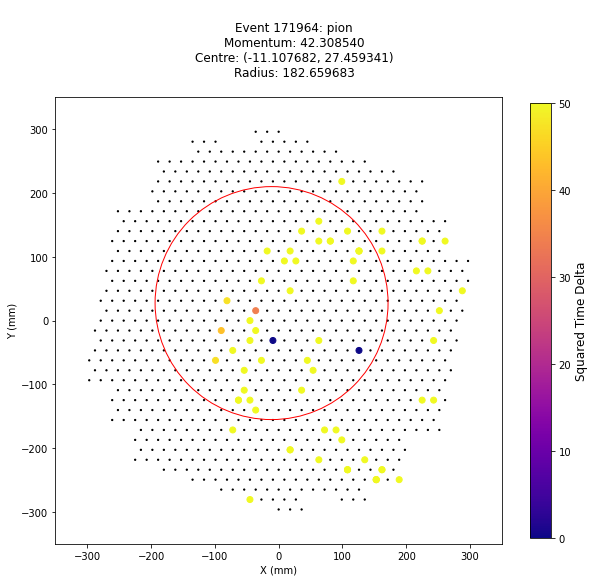

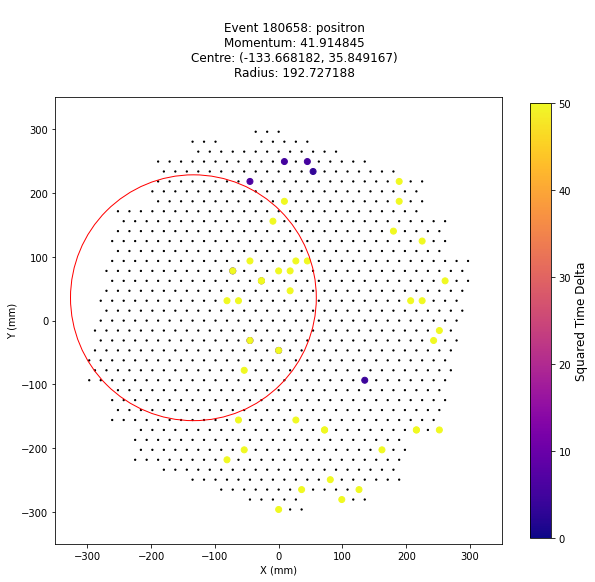

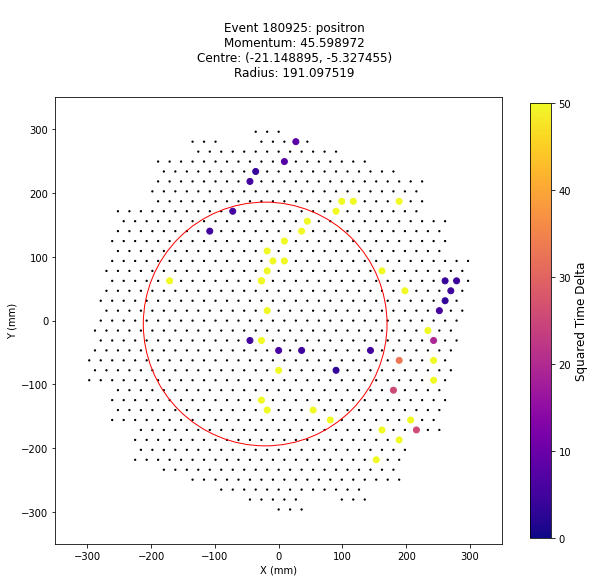

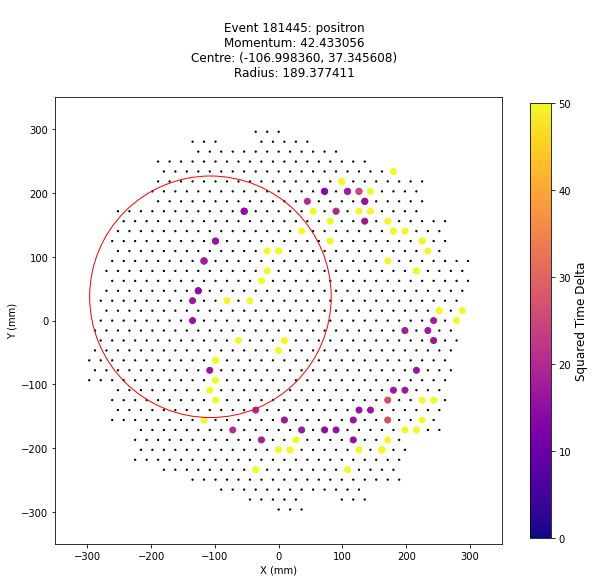

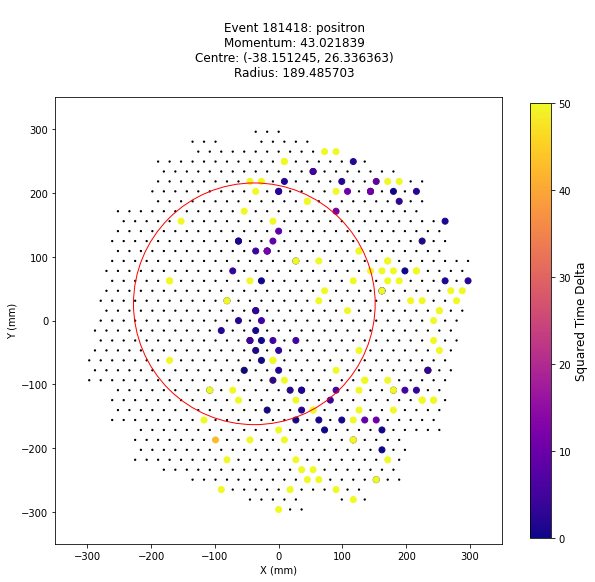

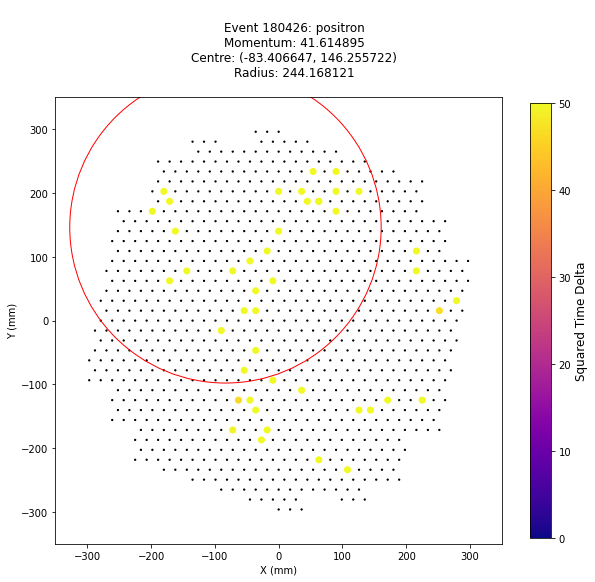

In [44]:
samples = get_class_samples(hits_df, n, seed, '40+')
plot_rings(samples)